# Datos

Usando la funcion parametros cargo los parametros fundamentales del script. 
Usando la funcion datos obtengo los valores de los datos a utilizar


Cargando datos 

Cargando track y transformando coordenadas 

Initializing galstreams library from master_log... 


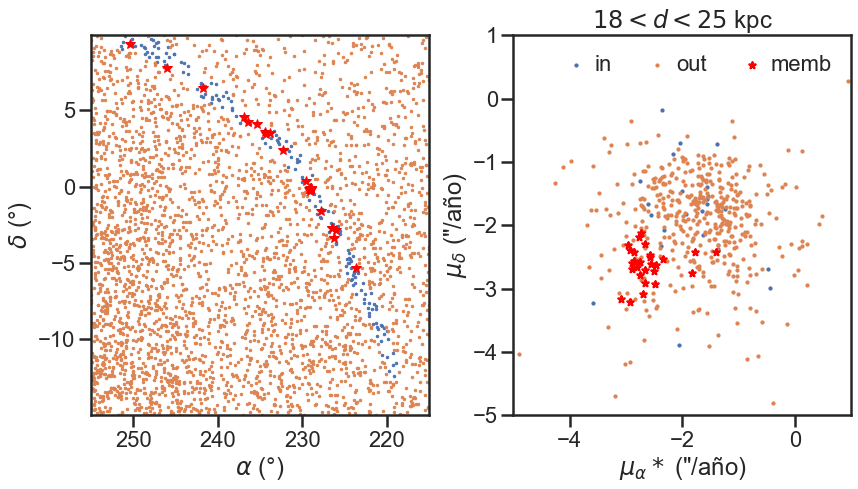

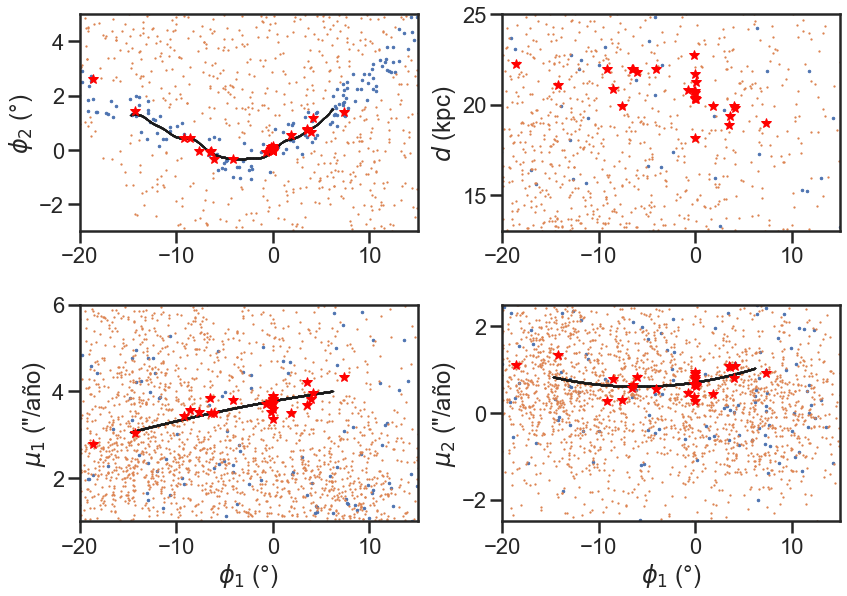

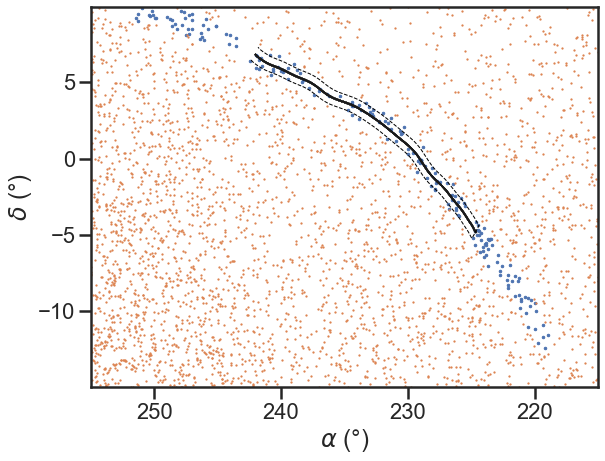

In [208]:
import parametros
import datos
import numpy as np

tabla, st, printTrack, do_bg_model, printBIC, N_inf, N_sup, d_inf, d_sup, C11, C22, C33, d_mean, e_dd, mu1_mean, mu2_mean, e_mu1, e_mu2, cov_mu, lim_unif, nwalkers, ndim, steps, burn_in, thin, q_min, q_max = parametros.parametros()
data, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, phi1_t, phi2_t, pmphi1_t, pmphi2_t, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out, footprint = datos.datos(tabla, st, 'yes', d_inf, d_sup)

y = np.array([pmphi1.value, pmphi2.value, d])
C = np.array([[C11, 0, 0], [0, C22, 0], [0, 0, C33]]) #Matriz de covarianza: Fija para todas las estrellas

#Parametros para el prior gaussiano de los movimientos propios en el frame de la corriente
mu = np.array([mu1_mean, mu2_mean])
sigma = np.array([[(e_mu1*10)**2, (cov_mu*100)], [(cov_mu*100), (e_mu2*10)**2]]) 

# Background

A partir del numero de gaussianas dado se calcula/carga la ln_like del fondo para cada estrella


Calculando modelo de fondo y BIC
N = 7
C:\Users\win8.1\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(

GMM_7 converge: True


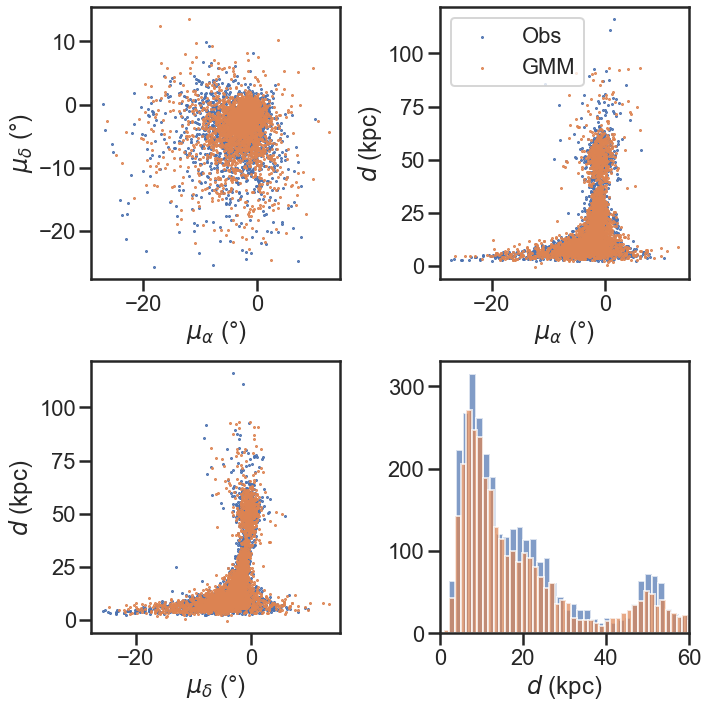

In [3]:
import fondo

N = np.arange(N_inf, N_sup) #Vector con numero de gaussianas
ll_bgn, p_bgn, gmm_best, BIC = fondo.fondo('yes', printBIC, N, pmra, pmdec, d, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out)

## Normalizacion probabilidad del fondo

Primero pruebo intergrando directamente

In [27]:
from scipy import integrate
from sklearn.mixture import GaussianMixture
import fondo

X = np.vstack([pmra_out, pmdec_out, d_out]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([e_pmra_out**2, e_pmdec_out**2, e_d_out**2]).T

N = np.arange(6,7)
models_gmm = fondo.compute_GaussianMixture(N, X)

# def lnlike_bg(pmra, pmdec, d):
#     return models_gmm[0].score_samples(np.vstack([pmra, pmdec, d]).T)

def like_bg(pmra, pmdec, d):
    return np.exp(models_gmm[0].score_samples(np.vstack([pmra, pmdec, d]).T))

int_nquad = integrate.nquad(like_bg, [[min(pmra),max(pmra)], [min(pmdec),max(pmdec)], [min(d),max(d)]])
print('\nint_nquad: ', int_nquad[0])

GMM_6 converge: True

int_nquad:  0.9947186097444838


Pruebo calculando la fracción de volumen de puntos dentro de volumen conocido

In [10]:
from scipy.optimize import minimize

def like_bg_op(param):#pmra, pmdec, d):
    pmra, pmdec, d = param
    return -np.exp(models_gmm[0].score_samples(np.vstack([pmra, pmdec, d]).T))

nmax = np.argmax(like_bg(pmra, pmdec, d))
x0 = [pmra[nmax], pmdec[nmax], d[nmax]]
res = minimize(like_bg_op, x0)
xmax = res.x

ymax = like_bg(xmax[0], xmax[1], xmax[2])[0]

print('x0: ',x0)
print('xmax: ',xmax)
print('ymax: ',ymax)

x0:  [-1.431, -1.559, 25.04]
xmax:  [-1.55610208 -1.56183076 24.10666586]
ymax:  0.006900488401738949


In [35]:
n = 1000000
pmra_unif = np.random.uniform(min(pmra), max(pmra), n)
pmdec_unif = np.random.uniform(min(pmdec), max(pmdec), n)
d_unif = np.random.uniform(min(d), max(d), n)
h_unif = np.random.uniform(0, ymax, n)

suma = 0.
for i in range(n):
    h = like_bg(pmra_unif[i], pmdec_unif[i], d_unif[i])[0]
    if h > h_unif[i]:
        suma += 1
frac = suma/n
int_suma = (max(pmra)-min(pmra))*(max(pmdec)-min(pmdec))*(max(d)-min(d))*ymax*frac

print('int_suma: ', int_suma)

int_suma:  0.9956603773258728


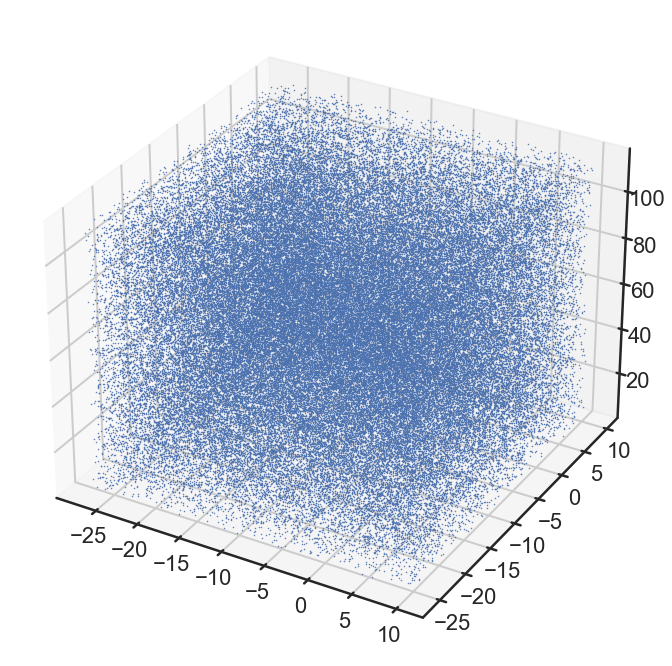

In [34]:
import pylab as plt
import scipy
import seaborn as sns
sns.set(style="ticks", context="poster")

fig = plt.figure(1,figsize=(12,12))
ax = plt.axes(projection='3d')
ax.plot3D(pmra_unif, pmdec_unif, d_unif,'.',ms=1)

In [65]:
def fun(paramt):
    # print(paramt)  # <-- As you can see, params is an array in NumPy.
    x, y, z = paramt # <-- You might want to give the component variables names to make them easier to read.
    return x**2 + y**3 + z**3

first_guess = [0.5, 0.5, 0.5]
res = minimize(fun, first_guess)
res.x

array([ -3.81330669, -17.13624291, -17.13624291])

In [48]:
def prueba(x,y):
    return x**2+3*y**2

integrate.nquad(prueba, [[1,2],[0,1]])


(3.3333333333333335, 5.906740616163359e-14)

# test ln_unif

In [9]:
#test1: lim_inf > lim_sup
test1 = probs.ln_unif(1,3,2)

#tes2: todo valor pertenece
p = np.random.uniform(-10000,10000,100)
test2 = np.zeros(100)
for i in range(len(p)):
    test2[i] = probs.ln_unif(p[i],-np.infty, np.infty)
if test2.sum() != 0.0:
    print('Error: p cae fuera del rango maximo')
    
#test3: p=lim_inf=lim_sup
test3 = probs.ln_unif(1,1,1)
print(test3)

Error: lim_inf > lim_sup
-inf


# test lnlike_st

In [6]:
import probs
import init

In [207]:
miembro_PW.sum()/phi1.value.size

0.008181818181818182

In [7]:
miembro_PW = (data['Track']==1) & (data['Memb']>0.5)
theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081, miembro_PW.sum()/phi1.value.size])
a_mu1, a_mu2, a_d, b_mu1, b_mu2, b_d, c_mu1, c_mu2, c_d, x_mu1, x_mu2, x_d, f = theta_true

## Revision de cuentas
Prueba de que el álgebra está correcta para el likelihood del stream. Esto es lo único que hay que chequear xq los theta son variables y estoy usando los del paper para comprobar la funcion



Primero simplemente utilizo la función para calcular el ln_likelihood de todas las estrellas y poder comparar con las pruebas

In [18]:
probs.phi1 = phi1
probs.y = y
probs.C = C

ll_st = probs.lnlike_st(theta_true[0:12])

ll_st[0:6]

array([-5.04436763,  3.62882094, -1.71621667, -4.30981768,  1.74417707,
       -7.06676374])

Calculo paso a paso lo que la función hace para dos estrellas, verificando a mano los resultados. Estos valores coinciden, por lo que las cuentas las hace de la forma que se prentende

In [5]:
#Valores paso a paso para las 2 primeras estrellas

xx=phi1[0:2].value
yy=np.array([[3.89836101, 3.80984264], [0.64737502, 0.6604234], [21.24, 20.73]])
CC=np.array([[0.0025, 0, 0], [0, 0.0025, 0], [0, 0, 0.04]])
norm = np.log((2*np.pi)**y.shape[0] * np.linalg.det(C))

model_mu1 = init.model(xx, a_mu1, b_mu1, c_mu1, x_mu1)
model_mu2 =init.model(xx, a_mu2, b_mu2, c_mu2, x_mu2)
model_d = init.model(xx, a_d, b_d, c_d, x_d)
model = np.array([model_mu1, model_mu2, model_d])

print('phi1: ',xx)
print('y-model:\n', yy-model)
print('P. matrices:\n', np.matmul(np.matmul((yy-model).T,np.linalg.inv(C)),(yy-model)))
print('normalizancion: ', norm)
print('log_likelihood:\n', np.diagonal(-0.5*(np.matmul(np.matmul((yy-model).T,np.linalg.inv(C)),(yy-model)) + norm)))

# print(model_mu1)


phi1:  [ 0.04989683 -0.00846398]
y-model:
 [[ 0.11314923  0.0269429 ]
 [-0.07056969 -0.05554283]
 [ 0.71172402  0.19038503]]
P. matrices:
 [[19.77690894  6.17482358]
 [ 6.17482358  2.43053187]]
normalizancion:  -9.688173719856128
log_likelihood:
 [-5.04436761  3.62882092]


Calculo de forma no matricial para 1 estrella para comprobar que se obtiene lo mismo que de forma matricial, siendo esto afirmativo

In [9]:
xxx=phi1[0:1].value
yyy=np.array([[3.89836101], [0.64737502], [21.24]])

model_mu1 = init.model(xxx, a_mu1, b_mu1, c_mu1, x_mu1)
model_mu2 =init.model(xxx, a_mu2, b_mu2, c_mu2, x_mu2)
model_d = init.model(xxx, a_d, b_d, c_d, x_d)
model = np.array([model_mu1, model_mu2, model_d])

hh = yyy-model

(-0.5*(400*(hh[0]**2+hh[1]**2) + 25*(hh[2]**2) + norm))


array([-5.04436761])

Calculo del ln_likelihood usando la funcion multinormal de scipy, dando también los mismos resultados

In [185]:
from scipy.stats import multivariate_normal

model_mu1_t = init.model(phi1.value, a_mu1, b_mu1, c_mu1, x_mu1)
model_mu2_t =init.model(phi1.value, a_mu2, b_mu2, c_mu2, x_mu2)
model_d_t = init.model(phi1.value, a_d, b_d, c_d, x_d)
model_t = np.array([model_mu1_t, model_mu2_t, model_d_t])

ln_st = np.zeros(phi1.size)
for i in range(phi1.size):
    ln_st[i] = multivariate_normal.logpdf(y.T[i], mean=model_t.T[i], cov=C)

ln_st[0:6]

array([-5.04436763,  3.62882094, -1.71621667, -4.30981768,  1.74417707,
       -7.06676374])

In [191]:
ln_model = np.zeros(phi1.size)
for i in range(phi1.size):
    ln_model[i] = multivariate_normal.logpdf(model_t.T[i], mean=model_t.T[i], cov=C)

np.exp(ln_model)

array([126.98727187, 126.98727187, 126.98727187, ..., 126.98727187,
       126.98727187, 126.98727187])

## Integral debajo de la curva

Calculo integral debajo de la curva para verificar que está bien normalizado (integral=1)

Algunos puntos dan una probabilidad mayor a 1, esto no implica nada. El valor máximo de la función se da en la media (el exponente igual a cero), por lo que este da igual al valor de la normalización (126. ). Lo importante es que la integral sea 1, es decir que esté bien normalizado 

In [234]:
np.exp(-0.5*np.log((2*np.pi)**y.shape[0] * np.linalg.det(C)))

126.9872718684819

In [104]:
probs.phi1 = phi1
probs.y = y
probs.C = C
ll_st = probs.lnlike_st(theta_true[0:12])

mayor1 = np.exp(ln_st)>1.
print('prob: ',np.exp(ln_st[mayor1]))
index = np.where(mayor1)[0]
print('index: ',index)

prob:  [37.66837713  5.7211914   6.40754642  2.25857962 19.45107722]
index:  [ 1  4  6  8 34]


Por otro lado si, $ll_{st} < -744$, entonces el np.exp da 0.0

Hago el cálculo utilizando integrate.nquad sobre mi función modificada para poder hacer la integral

In [4]:
from scipy import integrate
import time
from scipy.stats import multivariate_normal

Cada punto tiene una gaussiana 3D diferente dado phi1, ya que la media varía según phi1 para los tres valores. En realidad, es la misma gaussiana pero con la media desplazada (la matriz de covarianza C es la misma para todas las estrellas)

Modifico mi función para que funcione al revés: Dado theta las variables son los pm y la d.

La integral funciona tal que para cada phi1, se calcula una media y con ella se hace la integral en los pm y d entre los valores min y max de cada uno. ~En casi todos los casos da cero (10^-25 ponele), y en algunos casos (como n=6 o 9) la integral no converge (en realidad, al menos para n=6 demora 2h43m pero converge y da 1)~

Lo que sucede es que como la matriz de covarianza C es *MUY* chica, la mayoría de los valores entre los valores min y max dan casi cero, entonces al hacer nquad que evalúa la función en determinados puntos (_ver cúales_) estos seguramente dan muy cercano a cero y de ahí el valor de la integral. Ahora, si los límites de la integración se hacen entre $\mu \pm 10\times\sigma$ (puntos donde la función tiene valores no pequeños), ahí la integral si da ~1

In [240]:
int_nquad_st = np.zeros(phi1.size)
time_ = np.zeros(phi1.size)

a_mu1, a_mu2, a_d, b_mu1, b_mu2, b_d, c_mu1, c_mu2, c_d, x_mu1, x_mu2, x_d = theta_true[0:12]
model_mu1 = a_mu1 + b_mu1*(phi1.value-x_mu1) + c_mu1*(phi1.value-x_mu1)**2
model_mu2 = a_mu2 + b_mu2*(phi1.value-x_mu2) + c_mu2*(phi1.value-x_mu2)**2
model_d = a_d + b_d*(phi1.value-x_d) + c_d*(phi1.value-x_d)**2

n = 170
for i in range(n):
# for i in np.arange(n,n+1):
    start = time.time()
    model = np.array([model_mu1, model_mu2, model_d])[:,i]
    
    def like_st_int(pmphi1, pmphi2, d):        
        y = np.array([pmphi1, pmphi2, d])
        return np.exp(-0.5 *(np.matmul( np.matmul((y - model).T , np.linalg.inv(C) ) , (y - model) )  + np.log((2*np.pi)**y.shape[0] * np.linalg.det(C))))

    # int_nquad_st[i] = integrate.nquad(like_st_int, [[min(pmphi1.value),max(pmphi1.value)], [min(pmphi2.value),max(pmphi2.value)], [min(d),max(d)]])[0]
    int_nquad_st[i] = integrate.nquad(like_st_int, [[model[0]-1.,model[0]+1.], [model[1]-1.,model[1]+1.], [model[2]-2.,model[2]+2.]])[0]

    end = time.time()
    time_[i] = end-start

print(int_nquad_st[0:n])
print(time_[0:n])

# print(int_nquad_st[n])
# print(time_[n])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[171.91065383 172.94254994 174.66176629 171.26711011 171.86590624
 171.08073783 174.74526215 171.00577736 175.57221437 175.91283727
 171.1261878  171.95878053 171.01435971 175.15091395 171.53992772
 171.20796776 174.96456552 171.16382146 171.61632681 171.11790967
 174.72763324 172.11261463 171.56462884 175.1095047  171.10880852
 171.83824492 170.96011233 175.19064045 171.78827119 172.40622735
 179.29456687 171.17406678 171.42341995 171.45266581 175.14278007
 172.17868352 171.2

Repito lo mismo con la funcion multinormal de scipy, mismas conclusión que para mi función

## Juego con los valores de theta

In [210]:
import pylab as plt
import scipy
import seaborn as sns
sns.set(style="ticks", context="poster")

In [219]:
theta_true

array([ 3.74000000e+00,  6.86000000e-01,  2.20220000e+01,  4.10200000e-02,
       -2.82600000e-02,  9.46000000e-03, -6.42300000e-04,  2.83200000e-03,
       -6.32700000e-03, -1.07200000e+00, -1.09540000e+01, -1.60810000e+01,
        8.18181818e-03])

(-10.0, 10.0)

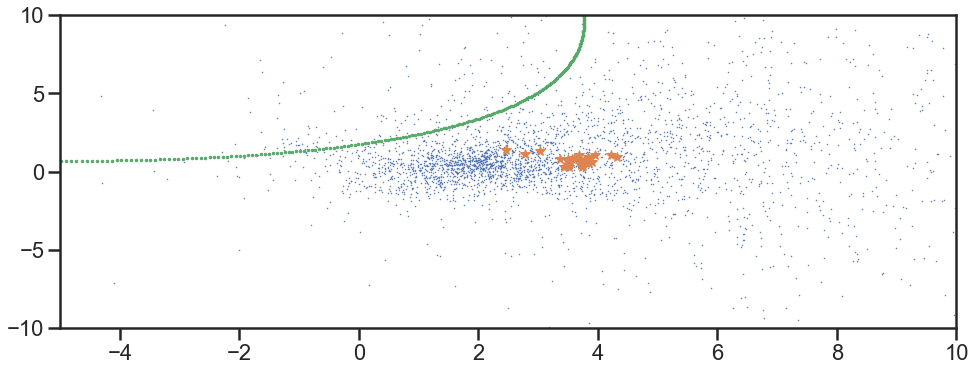

In [227]:
xx = np.linspace(min(phi1.value),max(phi1.value),1000)
bla = np.array([3.74000000e+00,  6.86000000e-01,  2.20220000e+01, -.1,0,.1, -.1,.1,0, -.1, -10, -15])

a_mu1, a_mu2, a_d, b_mu1, b_mu2, b_d, c_mu1, c_mu2, c_d, x_mu1, x_mu2, x_d = bla

model_mu1 = a_mu1 + b_mu1*(xx-x_mu1) + c_mu1*(xx-x_mu1)**2
model_mu2 = a_mu2 + b_mu2*(xx-x_mu2) + c_mu2*(xx-x_mu2)**2
model_d = a_d + b_d*(xx-x_d) + c_d*(xx-x_d)**2


fig=plt.figure(1,figsize=(15,5))
fig.subplots_adjust(wspace=0.4,hspace=0.3,top=0.98,bottom=0.11,left=0.14,right=0.97)
ax=fig.add_subplot(111)
ax.plot(pmphi1.value, pmphi2.value,'.', ms=1)
ax.plot(pmphi1.value[miembro_PW], pmphi2.value[miembro_PW],'*', ms=10)
ax.plot(model_mu1, model_mu2,'.', ms=5)

ax.set_xlim(-5,10)
ax.set_ylim(-10,10)

## Comparacion likelihood del fondo y del stream

Quiero probar:
- Las que son miembros efectivamente tienen mayor probabilidad de estar en el stream que estar en el fondo --> Evaluo ambos likelihoods para los theta_true y grafico.


    Si con los miembros funciona bien, pruebo con algunas del fondo para comparar esas también
    Si no funciona es que hay problemas con el calculo del ll del fondo o del stream (?

In [ ]:
import pylab as plt
import scipy
import seaborn as sns
sns.set(style="ticks", context="poster")

probs.phi1 = phi1
probs.y = y
probs.C = C
ll_st = probs.lnlike_st(theta_true[0:12])

#6 gaussianas
p_bgn6 = np.load('p_bgn6.npy')
ll_bgn6 = np.load('ll_bgn6.npy')
#7 gaussianas
p_bgn7 = np.load('p_bgn7.npy')
ll_bgn7 = np.load('ll_bgn7.npy')

miembros = (data['Track']==1) & (data['Memb']>0.5)
resto = ~miembros

In [ ]:
f = theta_true[12]
memb = np.exp(np.log(f)+ll_st - np.logaddexp(np.log(f)+ll_st, np.log(1.-f) + ll_bgn6))

In [146]:
print('Estrellas Miembros:')
print('Probabilidad de pertenecer al Stream:')
print(min(ll_st[miembros]))
print(max(ll_st[miembros]))
print('Probabilidad de pertenecer al Fondo:')
print(min(ll_bgn6[miembros]))
print(max(ll_bgn6[miembros]))

print('\nEstrellas del Fondo:')
print('Probabilidad de pertenecer al Stream:')
print(min(ll_st[resto]))
print(max(ll_st[resto]))
print('Probabilidad de pertenecer al Fondo:')
print(min(ll_bgn6[resto]))
print(max(ll_bgn6[resto]))

Estrellas Miembros:
Probabilidad de pertenecer al Stream:
-69.40955443346182
3.628820939655993
Probabilidad de pertenecer al Fondo:
-7.597400617315978
-6.018038680844636

Estrellas del Fondo:
Probabilidad de pertenecer al Stream:
-161578.6456803853
-1.5066812134716718
Probabilidad de pertenecer al Fondo:
-23.584886914216636
-4.993402214197376


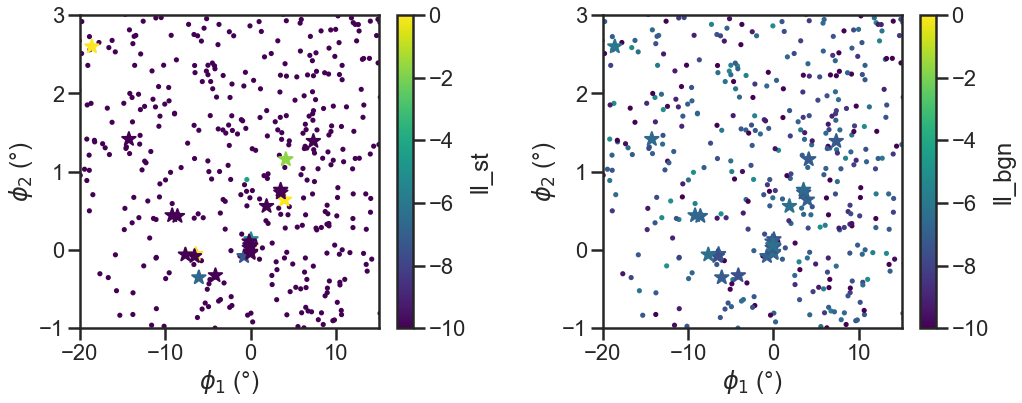

In [39]:
fig=plt.figure(1,figsize=(15,5))
fig.subplots_adjust(wspace=0.4,hspace=0.3,top=0.98,bottom=0.11,left=0.14,right=0.97)
ax=fig.add_subplot(121)
bla = ax.scatter(phi1[resto], phi2[resto], s=10, c=ll_st[resto], cmap='viridis', vmin=-10, vmax=0.)
bla = ax.scatter(phi1[miembros], phi2[miembros], s=200, marker='*',c=ll_st[miembros], cmap='viridis', vmin=-10, vmax=0.)
cb = plt.colorbar(bla, label='ll_st')
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\phi_2$ (°)')
ax.set_xlim([-20,15])
ax.set_ylim([-1,3])

ax=fig.add_subplot(122)
bla = ax.scatter(phi1[resto], phi2[resto], s=10, c=ll_bgn6[resto], cmap='viridis', vmin=-10, vmax=0.)
bla = ax.scatter(phi1[miembros], phi2[miembros], s=200, marker='*', c=ll_bgn6[miembros], cmap='viridis', vmin=-10, vmax=0.)
cb = plt.colorbar(bla, label='ll_bgn')
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\phi_2$ (°)')
ax.set_xlim([-20,15])
ax.set_ylim([-1,3]);


fig=plt.figure(1,figsize=(15,5))
fig.subplots_adjust(wspace=0.4,hspace=0.3,top=0.98,bottom=0.11,left=0.14,right=0.97)
ax=fig.add_subplot(121)
bla = ax.scatter(phi1[resto], phi2[resto], s=10, c=ll_st[resto], cmap='viridis', vmin=-10, vmax=0.)
bla = ax.scatter(phi1[miembros], phi2[miembros], s=200, marker='*',c=ll_st[miembros], cmap='viridis', vmin=-10, vmax=0.)
cb = plt.colorbar(bla, label='ll_st')
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\phi_2$ (°)')
ax.set_xlim([-20,15])
ax.set_ylim([-1,3])

ax=fig.add_subplot(122)
bla = ax.scatter(phi1[resto], phi2[resto], s=10, c=ll_bgn6[resto], cmap='viridis', vmin=-10, vmax=0.)
bla = ax.scatter(phi1[miembros], phi2[miembros], s=200, marker='*', c=ll_bgn6[miembros], cmap='viridis', vmin=-10, vmax=0.)
cb = plt.colorbar(bla, label='ll_bgn')
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\phi_2$ (°)')
ax.set_xlim([-20,15])
ax.set_ylim([-1,3]);


_Conclusiones:_

- En términos relativos, el likelihood del stream parece funcionar bien, es decir, la probailidad de las que son miembros es mayor a las del fondo en términos generales (igual hay estrellas del fondo con mayor probabilidad de ser del stream que las que son miembros.
- La probabilidad de pertenecer al fondo da raro, las estrellas miembros del stream tienen mayor probabilidad de pertenecer al fondo que varias de las que son del fondo (tanto para 6 como 7 gaussianas)
- Por otro lado, al comparar ambas probabilidades, la probabilidad de una estrella de pertenecer al stream es *mucho* menor a pertenecer al fondo, incluso para algunas de las que son miembro

Esto quiere decir que la probabilidad del fondo está mal? Pruebo correr MCMC sin el fondo para ver si se recuperan los parametros

## Corrida sin fondo

Impongo f=1 de forma que el fondo no contribuye en la MCMC, y solo utilizanmdo las estrellas miembros. Con esto compruebo si el likelihood del stream funciona correctamente. Por los valores tanto de theta como de la membresia parece funcionar correctamente

In [33]:
#Comprueba que la funcion de prueba funciona correctamente
a, b =probs.ln_posterior_prueba(theta_true, mu, sigma, d_mean, e_dd, lim_unif)
c =probs.ln_prior(theta_true, mu, sigma, d_mean, e_dd, lim_unif)
print(c)
print(a)
print(a-c)
print(b[0].sum())
probs.lnlike_st(theta_true[0:12]).sum()


-1.5381624974211814
-565.5194383815766
-563.9812758841555
-563.9812758841555


-563.9812758841555

In [18]:
import galstreams
#Galstreams
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)
track = mwsts[st].track
st_track = track.transform_to(mwsts[st].stream_frame)

phi1_t = st_track.phi1
phi2_t = st_track.phi2
pmphi1_t = st_track.pm_phi1_cosphi2
pmphi2_t = st_track.pm_phi2

Initializing galstreams library from master_log... 


Inicio:  2022-10-11 20:45:58.063433 


Cargando datos 

Cargando track y transformando coordenadas 

Initializing galstreams library from master_log... 

Modelo de fondo 


Cargando ll_bgn y p_bgn 

MCMC
Valores iniciales:  [ 3.74738665e+00  7.47412757e-01  2.10332153e+01  3.65011653e-02
  4.16815362e-02 -1.41448994e-01 -8.43218188e-04  2.90241029e-03
 -4.86381069e-03 -6.71315472e-01  1.83603764e+00 -3.18303887e+00
  8.18181818e-03]
C:\Users\win8.1\Documents\Fcien\Astronomia\galstreams\stream_memb\Price+2019\probs.py:172: RuntimeWarning: divide by zero encountered in log
  arg2 = np.log(1.-f) + ll_bgn



100%|██████████| 4096/4096 [07:00<00:00,  9.73it/s]


425.42365050315857
Tamano muestra: (42536, 13)
Guardando muestras 

Guardando membresias 



SolID                       DR2Name  Memb  inside10  \
0   1635721458409799680  Gaia DR2 4418724034151291776   1.0      True   
1   1635721458409799680  Gaia DR2 4418920808077110784   1.0      True   
2   1635721458409799680  Gaia DR2 6339398155830632448   1.0      True   
3   1635721458409799680  Gaia DR2 4418913218870688768   1.0      True   
4   1635721458409799680  Gaia DR2 4418726027016125056   1.0      True   
5   1635721458409799680  Gaia DR2 4427220338456828416   1.0      True   
6   1635721458409799680  Gaia DR2 4421078432143578496   1.0      True   
7   1635721458409799680  Gaia DR2 6339478312804685824   1.0      True   
8   1635721458409799680  Gaia DR2 4427234700827469952   1.0      True   
9   1635721458409799680  Gaia DR2 4418732791593809152   1.0      True   
10  1635721458409799680  Gaia DR2 4419052204012341760   1.0      True   
11  1635721458409799680  Gaia DR2 4418725889577171328   1.0      True   
12  1635721458409799680  Gaia DR2 6339499379619987200   1.0      True   
13  1635721458409799680  Gaia DR2 4424705647988505600   1.0      True   
14  1635721458409799680  Gaia DR2 6339498589346000768   1.0      True   
15  1635721458409799680  Gaia DR2 4427253907921168000   1.0      True   
16  1635721458409799680  Gaia DR2 4418920846732620032   1.0      True   
17  1635721458409799680  Gaia DR2 4426221707021159424   1.0      True   
18  1635721458409799680  Gaia DR2 6337233350579111680   1.0      True   
19  1635721458409799680  Gaia DR2 4418914863842345856   1.0      True   
20  1635721458409799680  Gaia DR2 4418142117622280192   1.0      True   
21  1635721458409799680  Gaia DR2 4418734165978521728   1.0      True   
22  1635721458409799680  Gaia DR2 4427646704153765632   1.0      True   
23  1635721458409799680  Gaia DR2 4439927909737905280   1.0      True   
24  1635721458409799680  Gaia DR2 4445607604551159040   1.0      True   
25  1635721458409799680  Gaia DR2 4418731829516302848   1.0      True   
26  1635721458409799680  Gaia DR2 4450058431917932672   1.0      True   

    inside50  
0       True  
1       True  
2       True  
3       True  
4       True  
5       True  
6       True  
7       True  
8       True  
9       True  
10      True  
11      True  
12      True  
13      True  
14      True  
15      True  
16      True  
17      True  
18      True  
19      True  
20      True  
21      True  
22      True  
23      True  
24      True  
25      True  
26      True

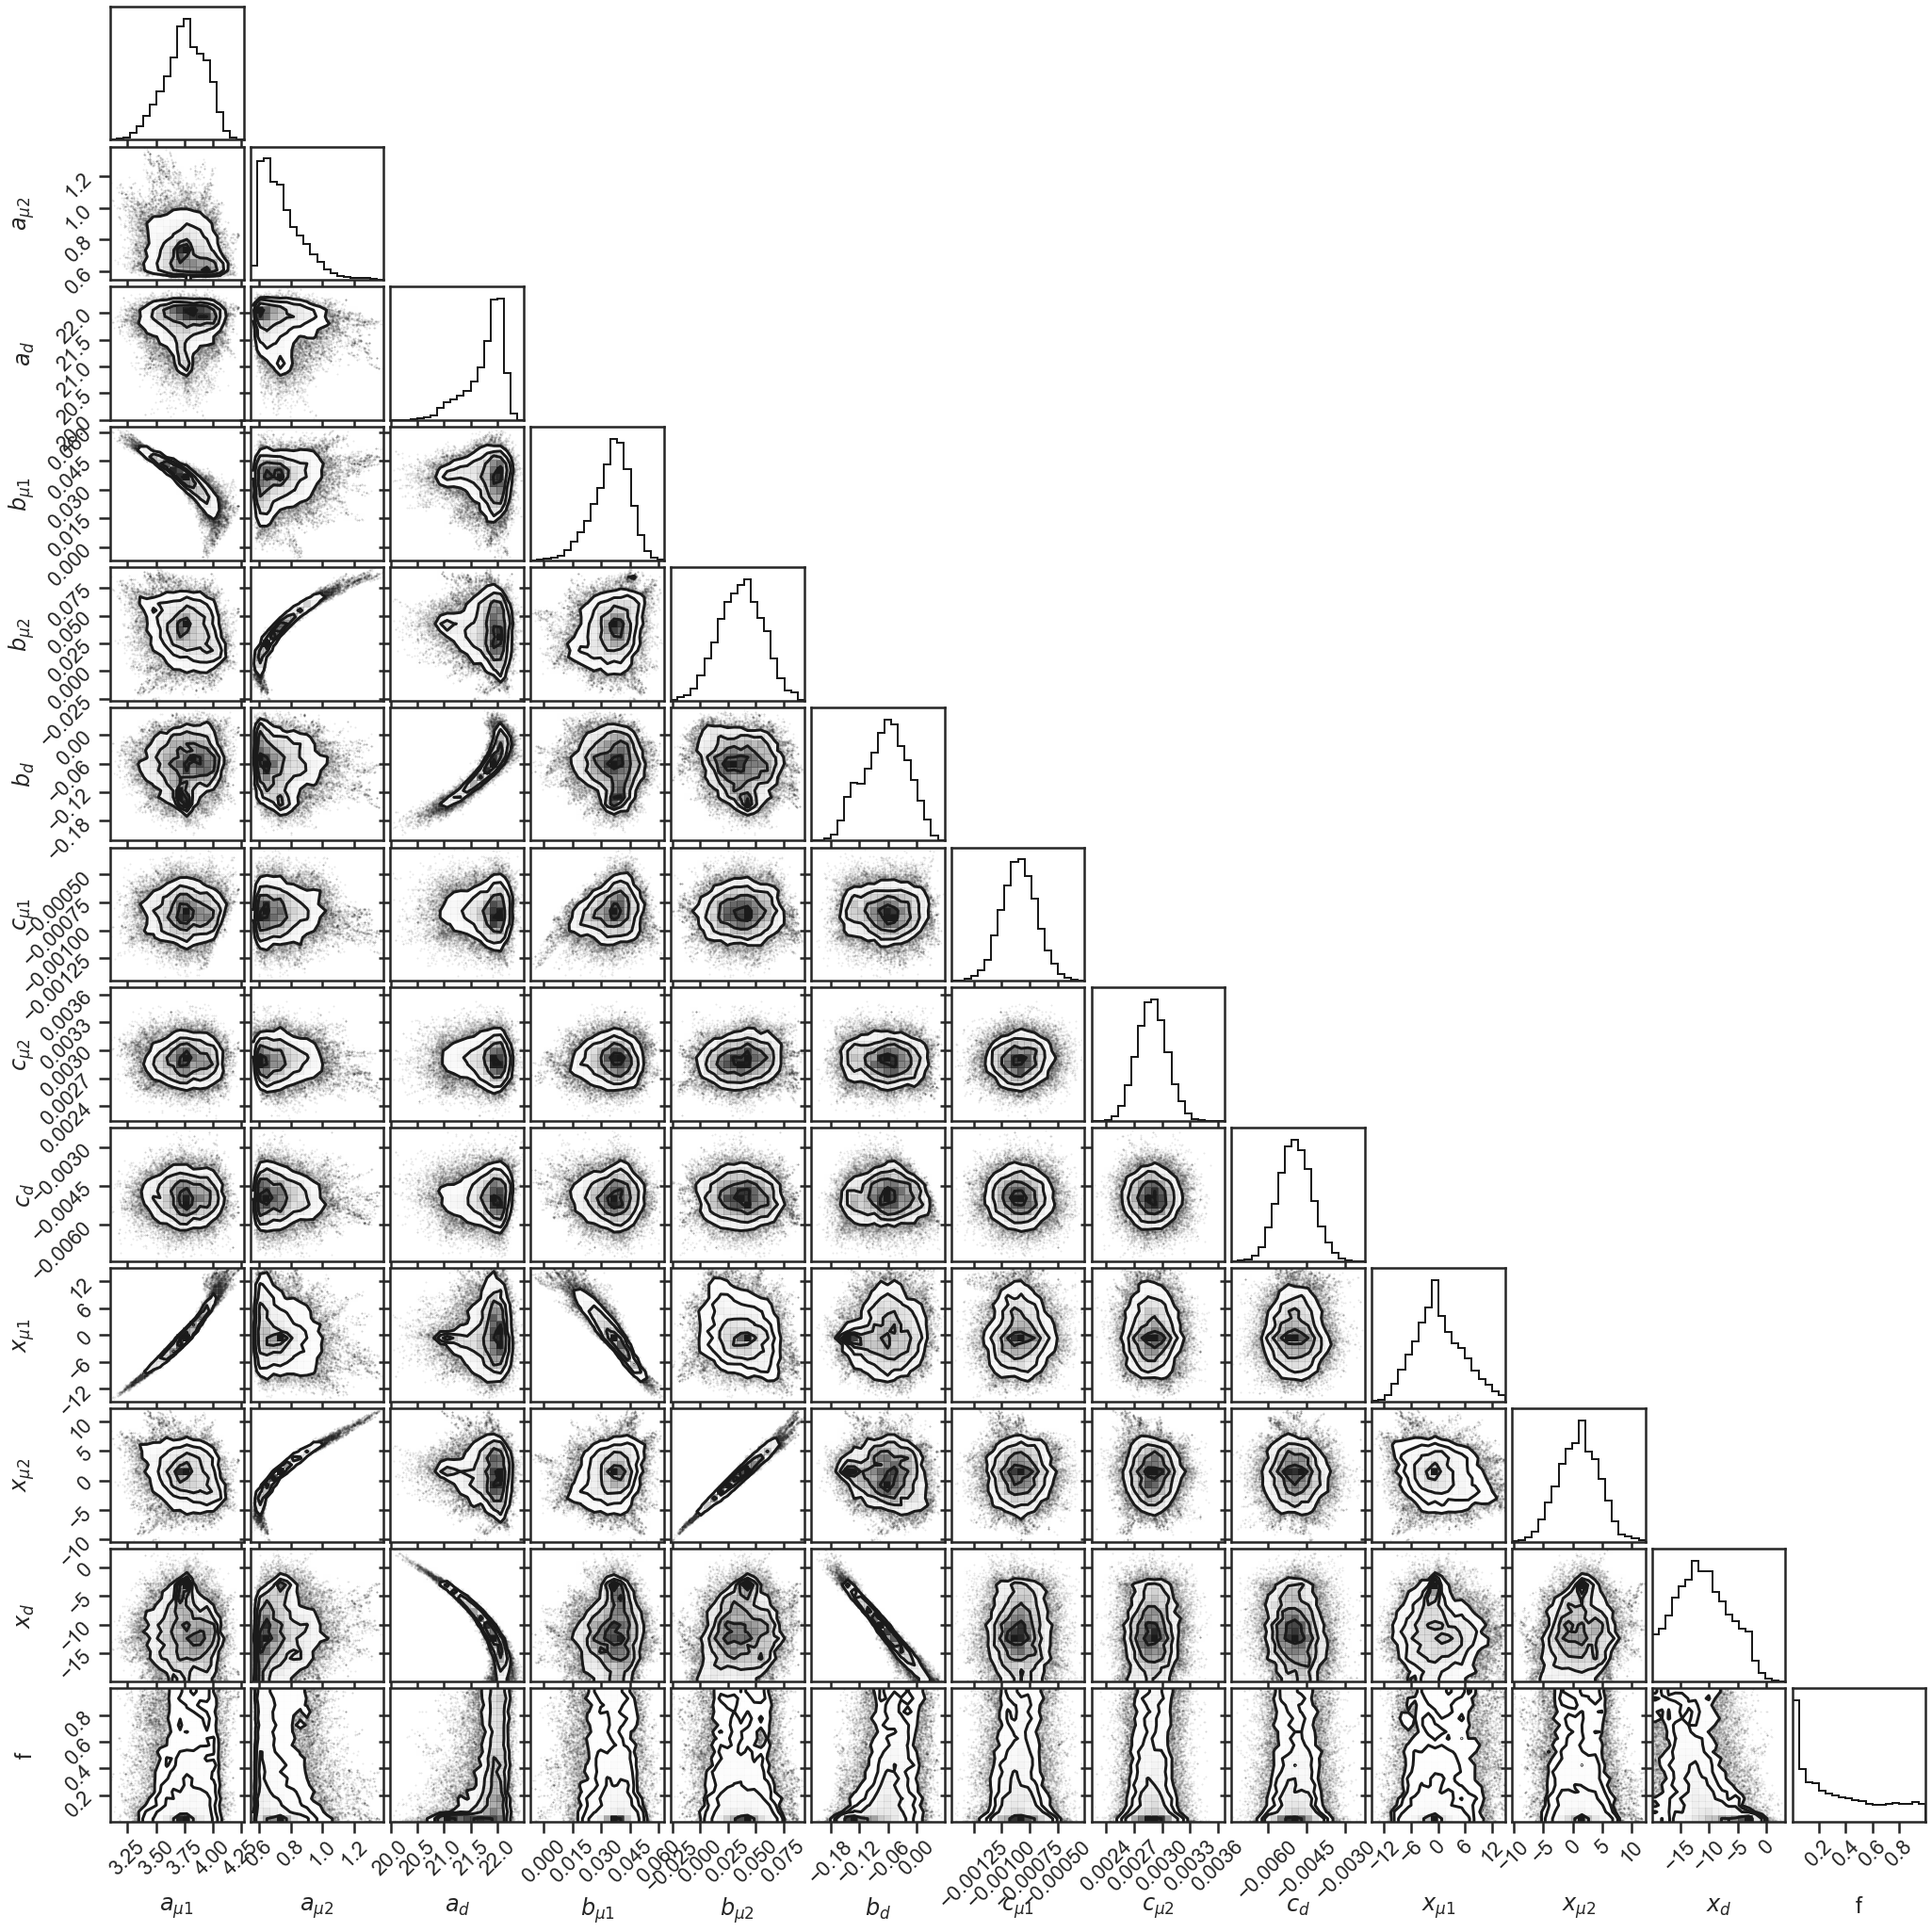

In [22]:
import parametros
import datos
import fondo
import probs
import init
import resultados 
# import blobs_aux

import numpy as np
import pandas as pd
import pylab as plt
import scipy
import seaborn as sns
sns.set(style="ticks", context="poster")

import emcee
import datetime, time
import corner	


Start = datetime.datetime.now()

print('Inicio: ', Start, '\n')

# print('Cargo datos \n')
tabla, st, printTrack, do_bg_model, printBIC, N_inf, N_sup, d_inf, d_sup, C11, C22, C33, d_mean, e_dd, mu1_mean, mu2_mean, e_mu1, e_mu2, cov_mu, lim_unif, nwalkers, ndim, steps, burn_in, thin, q_min, q_max = parametros.parametros()

data, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, phi1_t, phi2_t, pmphi1_t, pmphi2_t, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out, footprint = datos.datos(tabla, st, printTrack, d_inf, d_sup)

miembro_PW = (data['Track']==1) & (data['Memb']>0.5)

y = np.array([pmphi1.value[miembro_PW], pmphi2.value[miembro_PW], d[miembro_PW]])
C = np.array([[C11, 0, 0], [0, C22, 0], [0, 0, C33]]) #Matriz de covarianza de la corriente: mov propios y distancia (fija)

mu = np.array([mu1_mean, mu2_mean])
sigma = np.array([[(e_mu1*10)**2, (cov_mu*100)], [(cov_mu*100), (e_mu2*10)**2]]) #Matriz de covarianza del prior gaussiano de los movimientos propios en el frame de la corriente

#Para que funcione tengo que primero asignarle las variables globales al modulo probs
probs.phi1 = phi1[miembro_PW]
probs.y = y
probs.C = C

print('\nModelo de fondo \n')
N = np.arange(N_inf, N_sup) #Vector con numero de gaussianas
ll_bgn, p_bgn, gmm_best, BIC = fondo.fondo(do_bg_model, printBIC, N, pmra, pmdec, d, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out)

probs.ll_bgn = ll_bgn[miembro_PW]
probs.p_bgn = p_bgn[miembro_PW]


print('MCMC')
pos0 = init.init_ls(phi1, pmphi1, pmphi2, d, miembro_PW, nwalkers, ndim) #Inicializo haciendo minimos cuadrados con las estrellas que ya se que son miembros segun PW2019

#SERIAL RUN
dtype = [("(arg1, arg2)", object)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, probs.ln_posterior_prueba, args=(mu, sigma, d_mean, e_dd, lim_unif), blobs_dtype=dtype)
start = time.time()
pos, _, _, _ = sampler.run_mcmc(pos0, burn_in, progress=True)
sampler.reset()
sampler.run_mcmc(pos, steps, progress=True)
end = time.time()
serial_time = end-start
print(serial_time)

# tau = sampler.get_autocorr_time()
# print('tau: ', tau)
# print('tau promedio: {}'.format(np.mean(tau)))

flat_samples = sampler.get_chain(discard=0, thin=thin, flat=True)
print('Tamano muestra: {}'.format(flat_samples.shape))

columns = ["$a_{\mu1}$", "$a_{\mu2}$", "$a_d$", "$b_{\mu1}$", "$b_{\mu2}$", "$b_d$", "$c_{\mu1}$", "$c_{\mu2}$", "$c_d$", "$x_{\mu1}$", "$x_{\mu2}$", "$x_d$", "f"]
theta_post = pd.DataFrame(flat_samples, columns=columns)


fig6 = corner.corner(flat_samples, labels=columns, labelpad=0.25)
fig6.subplots_adjust(bottom=0.05,left=0.05)
fig6.savefig('corner_plot_sinfondo.png')


print('Guardando muestras \n')

##Guardo las posteriors
post = sampler.get_log_prob(discard=0, thin=thin, flat=True)

theta_post['Posterior'] = post
theta_post.to_csv('theta_post_sinfondo.csv', index=False)


print('Guardando membresias \n')

##Prob de membresia al stream
flat_blobs = sampler.get_blobs(discard=0, thin=thin, flat=True)
memb = resultados.memb(phi1[miembro_PW], flat_blobs)

inside10 = memb > 0.1 
inside50 = memb > 0.5

Memb = pd.DataFrame({'SolID': data['SolID'][miembro_PW], 'DR2Name': data['DR2Name'][miembro_PW], 'Memb': memb,'inside10': inside10, 'inside50': inside50})
Memb.to_csv('memb_prob_sinfondo.csv', index=False)

Memb

MAP del MCMC:
  [ 3.95150559e+00  6.05209941e-01  2.20417592e+01  1.69376948e-02
  1.65631731e-02 -6.52466437e-02 -1.00164054e-03  3.04914876e-03
 -5.33760565e-03  7.12704436e+00 -3.35673985e+00 -1.15541007e+01
  9.99920678e-01] 

Valores del paper: 
 [ 3.74000000e+00  6.86000000e-01  2.20220000e+01  4.10200000e-02
 -2.82600000e-02  9.46000000e-03 -6.42300000e-04  2.83200000e-03
 -6.32700000e-03 -1.07200000e+00 -1.09540000e+01 -1.60810000e+01
  8.18181818e-03]


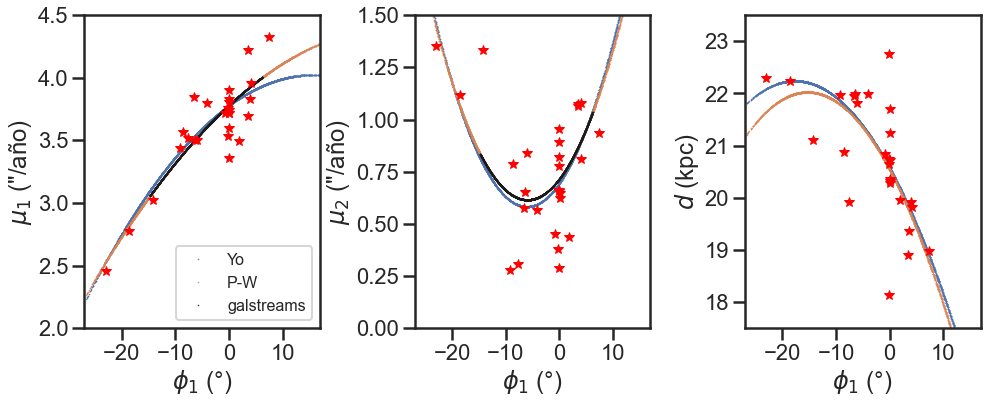

In [23]:
import init

miembro = (data['Track']==1) & (data['Memb']>0.5)

post = flat_samples[:, -1]
    
MAP = max(post)
theta_max = flat_samples[np.argmax(post)]

print('MAP del MCMC:\n ', theta_max,'\n')
print('Valores del paper: \n',theta_true)


#MCMCM
y_mu1 = init.model(phi1.value, theta_max[0], theta_max[3], theta_max[6], theta_max[9])
y_mu2 = init.model(phi1.value, theta_max[1], theta_max[4], theta_max[7], theta_max[10])
y_d = init.model(phi1.value, theta_max[2], theta_max[5], theta_max[8], theta_max[11])

#Paper
yy_mu1 = init.model(phi1.value, theta_true[0], theta_true[3], theta_true[6], theta_true[9])
yy_mu2 = init.model(phi1.value, theta_true[1], theta_true[4], theta_true[7], theta_true[10])
yy_d = init.model(phi1.value, theta_true[2], theta_true[5], theta_true[8], theta_true[11])


fig=plt.figure(1,figsize=(15,5))
fig.subplots_adjust(wspace=0.4,hspace=0.3,top=0.98,bottom=0.11,left=0.14,right=0.97)
ax=fig.add_subplot(131)
ax.plot(phi1, y_mu1,'.', ms=1, label='Yo')
ax.plot(phi1, yy_mu1,'.', ms=1, label='P-W')
ax.plot(phi1_t, pmphi1_t,'k.', ms=1, label='galstreams')
ax.plot(phi1[miembro],pmphi1[miembro],'*',c='red',ms=10.)
ax.legend(fontsize=16,loc='lower right')
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_1$ ("/año)')
ax.set_xlim([-27,17])
ax.set_ylim([2.,4.5])
# ax.set_xlim([-16,8])
# ax.set_ylim([3.,4.1])

ax=fig.add_subplot(132)
ax.plot(phi1, y_mu2,'.', ms=1)
ax.plot(phi1, yy_mu2,'.', ms=1)
ax.plot(phi1_t, pmphi2_t,'k.', ms=1)
ax.plot(phi1[miembro],pmphi2[miembro],'*',c='red',ms=10.)
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_2$ ("/año)')
ax.set_xlim([-27,17])
ax.set_ylim([0.,1.5])
# ax.set_xlim([-16,8])
# ax.set_ylim([0.5,1.2])

ax=fig.add_subplot(133)
ax.plot(phi1, y_d,'.', ms=1)
ax.plot(phi1, yy_d,'.', ms=1)
ax.plot(phi1[miembro],d[miembro],'*',c='red',ms=10.)
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$d$ (kpc)')
ax.set_xlim([-27,17])
ax.set_ylim([17.5,23.5]);

Los valores de los $a_i$, el $b_{\mu_1}$ y el $x_{d}$ (?) se recuperan relativamente bien, los $c_i$ son del mismo orden de magnitud, los demás o ni tienen el mismo orden de magintud o son del signo opuesto o no se parecen.

Las parábolas, excepto la parte derecha de $\mu_1$, no son tan diferentes, todas tienen la misma concavidas (los $c_i$ son del mismo signo respectivamente) y no se alejan mucho entre si

Al comparar las parabolas con las estrellas que son miembros, a simple vista cualquiera de las dos parábolas podría ser un buen ajuste.

Las parábolas de galstreams para los movimientos propios parecen coincidir con los valores de P-W19. Haciendo mínimos cuadrados sobre los puntos de los tracks en mov propios de galstreams, algunos de los parámetros tampco coinciden pero al graficar estas diferencias son despreciables.

Valores galstream:
 [ 3.85515258e+00  7.85439058e-01  3.72396336e-02  4.38756583e-02
 -6.42300000e-04  2.83199994e-03  1.85637653e+00  1.76735685e+00] 

Valores P-W19:
 [ 3.7400e+00  6.8600e-01  4.1020e-02 -2.8260e-02 -6.4230e-04  2.8320e-03
 -1.0720e+00 -1.0954e+01] 

MAP del MCMC:
  [ 3.88094839e+00  6.91612500e-01  4.27234794e-02  3.47936873e-02
 -3.27502536e-04  3.02273532e-03  2.69014704e+00  5.01288928e-01] 



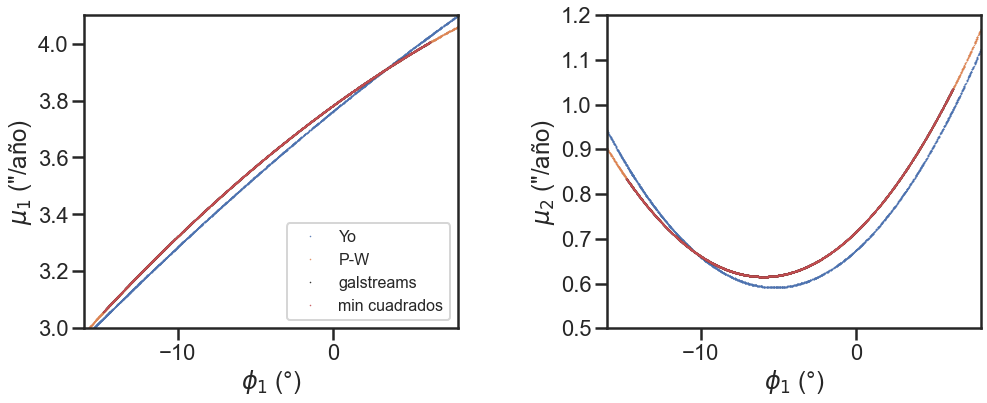

In [91]:
#Comparo los paramentros de los mov propios de galstreams, PW19 y los calculados para las estrellas miembro
from scipy.optimize import curve_fit

params_mu1, _ = curve_fit(init.model, phi1_t.value, pmphi1_t.value)
params_mu2, _ = curve_fit(init.model, phi1_t.value, pmphi2_t.value)
    
theta_galst = np.array([params_mu1[0], params_mu2[0], params_mu1[1], params_mu2[1], params_mu1[2], params_mu2[2], params_mu1[3], params_mu2[3]])

y_gs_mu1 = init.model(phi1_t.value, theta_galst[0], theta_galst[2], theta_galst[4], theta_galst[6])
y_gs_mu2 = init.model(phi1_t.value, theta_galst[1], theta_galst[3], theta_galst[5], theta_galst[7])

print('Valores galstream:\n', theta_galst,'\n')
print('Valores P-W19:\n',theta_true[[0,1,3,4,6,7,9,10]],'\n')
print('MAP del MCMC:\n ', theta_max[[0,1,3,4,6,7,9,10]],'\n')


fig=plt.figure(1,figsize=(15,5))
fig.subplots_adjust(wspace=0.4,hspace=0.3,top=0.98,bottom=0.11,left=0.14,right=0.97)
ax=fig.add_subplot(121)
ax.plot(phi1, y_mu1,'.', ms=1, label='Yo')
ax.plot(phi1, yy_mu1,'.', ms=1, label='P-W')
ax.plot(phi1_t, pmphi1_t,'k.', ms=1, label='galstreams')
ax.plot(phi1_t, y_gs_mu1,'r.', ms=1, label='min cuadrados')
ax.legend(fontsize=16,loc='lower right')
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_1$ ("/año)')
ax.set_xlim([-16,8])
ax.set_ylim([3.,4.1])

ax=fig.add_subplot(122)
ax.plot(phi1, y_mu2,'.', ms=1, label='Yo')
ax.plot(phi1, yy_mu2,'.', ms=1, label='P-W')
ax.plot(phi1_t, pmphi2_t,'k.', ms=1, label='galstreams')
ax.plot(phi1_t, y_gs_mu2,'r.', ms=1, label='min cuadrados')
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_2$ ("/año)')
ax.set_xlim([-16,8])
ax.set_ylim([0.5,1.2]);

## Estrellas miembros N=6

Corrida del script solamente para las estrellas que son miembro según PW19, con N=6 gaussinas para el fondo. 

Al incorporar el fondo MCMC continúa convergiendo pero ahora da resultados muy malos, particularmente para $\mu_1$ y tal vez $\mu_2$.

Los resultados son muy sensibles a la corrida, cada corrida da resultados diferentes, particularmente para $\mu_1$ y $d$

Inicio:  2022-10-10 19:42:15.005618 


Cargando datos 

Cargando track y transformando coordenadas 

Initializing galstreams library from master_log... 

Modelo de fondo 

MCMC
Valores iniciales:  [ 3.74738665e+00  7.47412757e-01  2.10332153e+01  3.65011653e-02
  4.16815362e-02 -1.41448994e-01 -8.43218188e-04  2.90241029e-03
 -4.86381069e-03 -6.71315472e-01  1.83603764e+00 -3.18303887e+00
  8.18181818e-03]


 16%|█▌        | 8/50 [00:00<00:03, 12.22it/s]

C:\Users\win8.1\Documents\Fcien\Astronomia\galstreams\stream_memb\Price+2019\probs.py:32: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta_st)

C:\Users\win8.1\Documents\Fcien\Astronomia\galstreams\stream_memb\Price+2019\probs.py:35: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



100%|██████████| 4096/4096 [05:42<00:00, 11.95it/s]


347.2680084705353
Tamano muestra: (42536, 13)


Guardando muestras 

Guardando membresias 



SolID                       DR2Name          Memb  inside10  \
0   1635721458409799680  Gaia DR2 4418724034151291776  4.936367e-01      True   
1   1635721458409799680  Gaia DR2 4418920808077110784  6.466831e-01      True   
2   1635721458409799680  Gaia DR2 6339398155830632448  2.630744e-01      True   
3   1635721458409799680  Gaia DR2 4418913218870688768  6.005157e-01      True   
4   1635721458409799680  Gaia DR2 4418726027016125056  1.951997e-02     False   
5   1635721458409799680  Gaia DR2 4427220338456828416  2.717572e-01      True   
6   1635721458409799680  Gaia DR2 4421078432143578496  5.424898e-01      True   
7   1635721458409799680  Gaia DR2 6339478312804685824  3.739802e-01      True   
8   1635721458409799680  Gaia DR2 4427234700827469952  3.182253e-01      True   
9   1635721458409799680  Gaia DR2 4418732791593809152  4.661220e-01      True   
10  1635721458409799680  Gaia DR2 4419052204012341760  6.250636e-01      True   
11  1635721458409799680  Gaia DR2 4418725889577171328  7.807720e-02     False   
12  1635721458409799680  Gaia DR2 6339499379619987200  2.549046e-02     False   
13  1635721458409799680  Gaia DR2 4424705647988505600  6.377033e-03     False   
14  1635721458409799680  Gaia DR2 6339498589346000768  1.023455e-01      True   
15  1635721458409799680  Gaia DR2 4427253907921168000  2.324959e-01      True   
16  1635721458409799680  Gaia DR2 4418920846732620032  2.780555e-03     False   
17  1635721458409799680  Gaia DR2 4426221707021159424  2.691604e-02     False   
18  1635721458409799680  Gaia DR2 6337233350579111680  4.993884e-02     False   
19  1635721458409799680  Gaia DR2 4418914863842345856  3.602308e-04     False   
20  1635721458409799680  Gaia DR2 4418142117622280192  4.590599e-02     False   
21  1635721458409799680  Gaia DR2 4418734165978521728  5.678533e-03     False   
22  1635721458409799680  Gaia DR2 4427646704153765632  4.028866e-10     False   
23  1635721458409799680  Gaia DR2 4439927909737905280  6.443277e-02     False   
24  1635721458409799680  Gaia DR2 4445607604551159040  5.916864e-02     False   
25  1635721458409799680  Gaia DR2 4418731829516302848  1.297944e-11     False   
26  1635721458409799680  Gaia DR2 4450058431917932672  1.693253e-03     False   

    inside50  
0      False  
1       True  
2      False  
3       True  
4      False  
5      False  
6       True  
7      False  
8      False  
9      False  
10      True  
11     False  
12     False  
13     False  
14     False  
15     False  
16     False  
17     False  
18     False  
19     False  
20     False  
21     False  
22     False  
23     False  
24     False  
25     False  
26     False

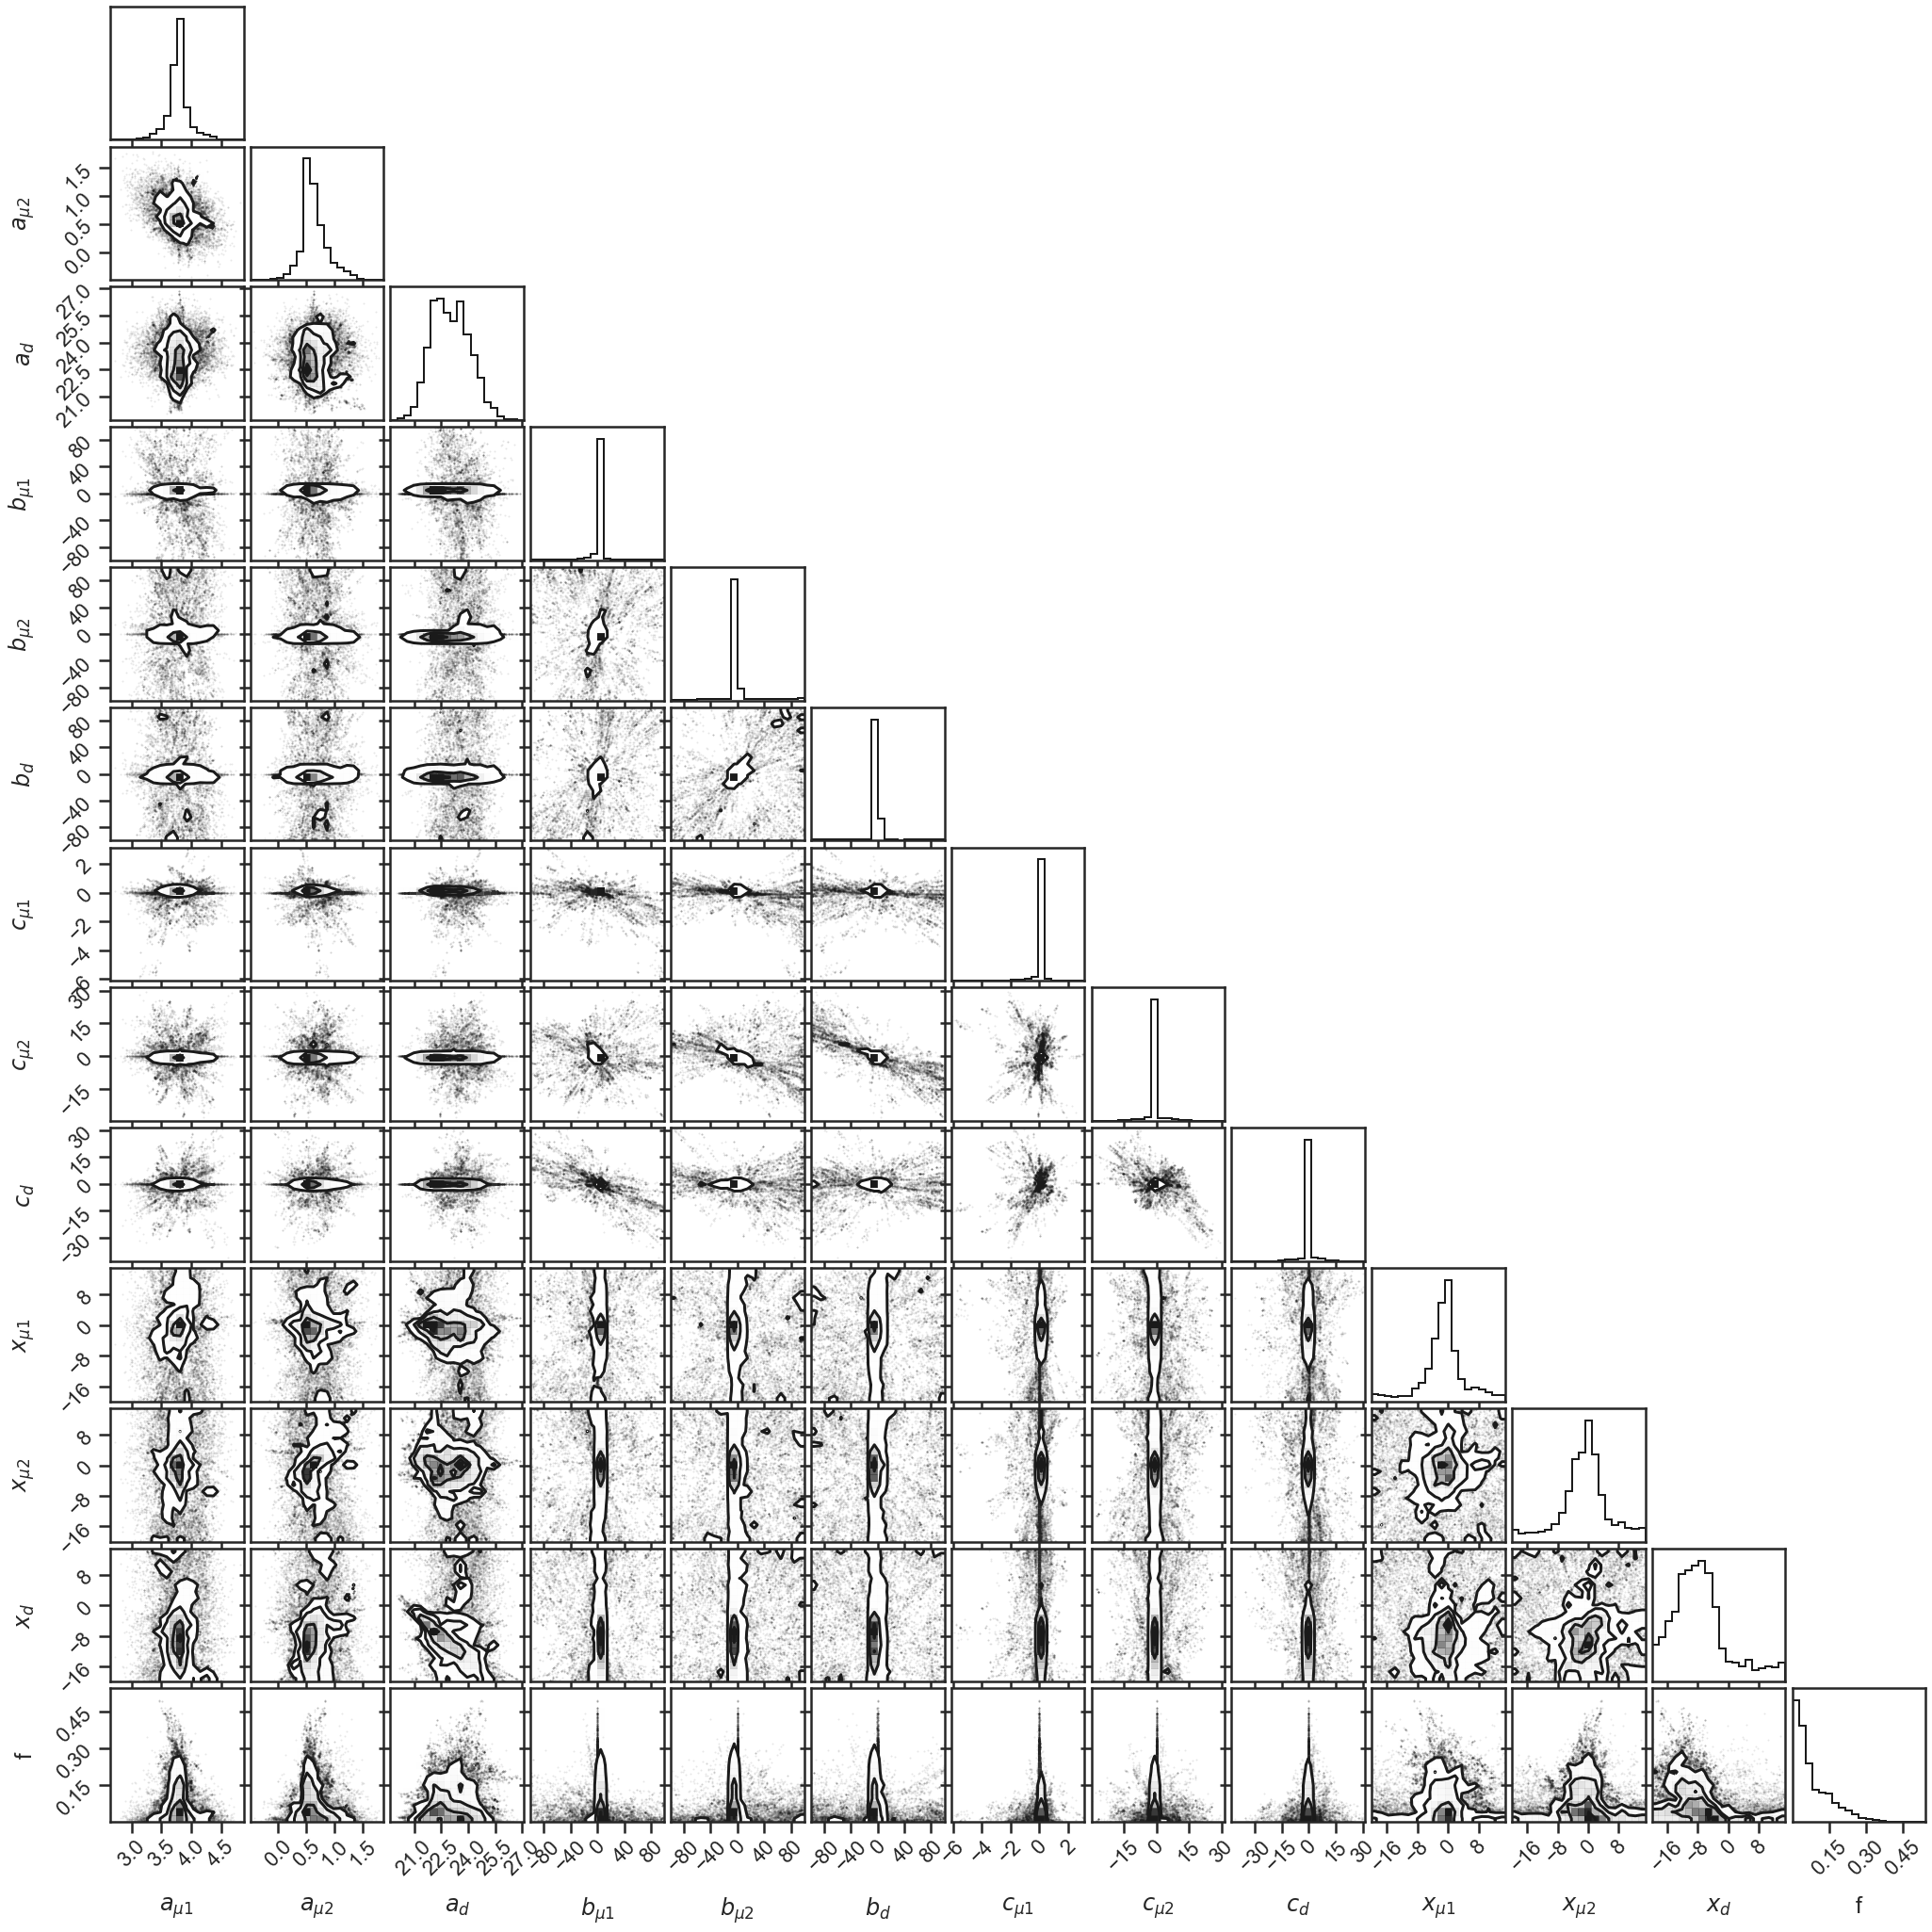

In [10]:
import parametros
import datos
import fondo
import probs
import init
import resultados 
# import blobs_aux

import numpy as np
import pandas as pd
import pylab as plt
import scipy
import seaborn as sns
sns.set(style="ticks", context="poster")


# import os #Avoids issues with paralellization in emcee
# os.environ["OMP_NUM_THREADS"] = "1"
# from multiprocessing import Pool
# from multiprocessing import cpu_count
import datetime, time
import emcee
import corner	


Start = datetime.datetime.now()

print('Inicio: ', Start, '\n')

# print('Cargo datos \n')
tabla, st, printTrack, do_bg_model, printBIC, N_inf, N_sup, d_inf, d_sup, C11, C22, C33, d_mean, e_dd, mu1_mean, mu2_mean, e_mu1, e_mu2, cov_mu, lim_unif, nwalkers, ndim, steps, burn_in, thin, q_min, q_max = parametros.parametros()

data, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, phi1_t, phi2_t, pmphi1_t, pmphi2_t, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out, footprint = datos.datos(tabla, st, printTrack, d_inf, d_sup)

miembro_PW = (data['Track']==1) & (data['Memb']>0.5)

y = np.array([pmphi1.value[miembro_PW], pmphi2.value[miembro_PW], d[miembro_PW]])
C = np.array([[C11, 0, 0], [0, C22, 0], [0, 0, C33]]) #Matriz de covarianza de la corriente: mov propios y distancia (fija)

mu = np.array([mu1_mean, mu2_mean])
sigma = np.array([[(e_mu1*10)**2, (cov_mu*100)], [(cov_mu*100), (e_mu2*10)**2]]) #Matriz de covarianza del prior gaussiano de los movimientos propios en el frame de la corriente

#Para que funcione tengo que primero asignarle las variables globales al modulo probs
probs.phi1 = phi1[miembro_PW]
probs.y = y
probs.C = C

print('\nModelo de fondo \n')
N = np.arange(N_inf, N_sup) #Vector con numero de gaussianas
# ll_bgn, p_bgn, gmm_best, BIC = fondo.fondo(do_bg_model, printBIC, N, pmra, pmdec, d, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out)
ll_bgn = np.load('ll_bgn6.npy')
p_bgn = np.load('p_bgn6.npy')

probs.ll_bgn = ll_bgn[miembro_PW]
probs.p_bgn = p_bgn[miembro_PW]


print('MCMC')
pos0 = init.init_ls(phi1, pmphi1, pmphi2, d, miembro_PW, nwalkers, ndim) #Inicializo haciendo minimos cuadrados con las estrellas que ya se que son miembros segun PW2019

#SERIAL RUN
dtype = [("(arg1, arg2)", object)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, probs.ln_posterior, args=(mu, sigma, d_mean, e_dd, lim_unif), blobs_dtype=dtype)
start = time.time()
pos, _, _, _ = sampler.run_mcmc(pos0, burn_in, progress=True)
sampler.reset()
sampler.run_mcmc(pos, steps, progress=True)
end = time.time()
serial_time = end-start
print(serial_time)

# tau = sampler.get_autocorr_time()
# print('tau: ', tau)
# print('tau promedio: {}'.format(np.mean(tau)))

flat_samples = sampler.get_chain(discard=0, thin=thin, flat=True)
print('Tamano muestra: {}'.format(flat_samples.shape))

columns = ["$a_{\mu1}$", "$a_{\mu2}$", "$a_d$", "$b_{\mu1}$", "$b_{\mu2}$", "$b_d$", "$c_{\mu1}$", "$c_{\mu2}$", "$c_d$", "$x_{\mu1}$", "$x_{\mu2}$", "$x_d$", "f"]
theta_post = pd.DataFrame(flat_samples, columns=columns)


fig6 = corner.corner(flat_samples, labels=columns, labelpad=0.25)
fig6.subplots_adjust(bottom=0.05,left=0.05)
fig6.savefig('corner_plot_miembros6.png')


print('Guardando muestras \n')

##Guardo las posteriors
post = sampler.get_log_prob(discard=0, thin=thin, flat=True)

theta_post['Posterior'] = post
theta_post.to_csv('theta_post_miembros6.csv', index=False)


print('Guardando membresias \n')

##Prob de membresia al stream
flat_blobs = sampler.get_blobs(discard=0, thin=thin, flat=True)
memb = resultados.memb(phi1[miembro_PW], flat_blobs)

inside10 = memb > 0.1 
inside50 = memb > 0.5

Memb = pd.DataFrame({'SolID': data['SolID'][miembro_PW], 'DR2Name': data['DR2Name'][miembro_PW], 'Memb': memb,'inside10': inside10, 'inside50': inside50})
Memb.to_csv('memb_prob_miembros6.csv', index=False)

Memb

Grafico parábolas obtenidas con la posterior completa utilizando N=6 gaussianas en el modelo del fondo. Se puede ver como esta vez (en comparación con las obtenidas apagando el fondo), las parábolas *no* son similares para nada, incluso la concavidad de la $\mu_1$ es la opuesta y crece mucho más rápido (es decir, $c_{\mu_1}^{Yo} > -c_{\mu_1}^{PW19}$ ), para $\mu_2$ sí es de la misma concavidad pero crece má rápido ( $c_{\mu_2}^{Yo} > c_{\mu_2}^{PW19}$ )

MAP del MCMC:
  [ 3.64600088e+00  7.03254675e-01  2.41693431e+01  6.65924999e-02
  1.07597049e-01 -3.38025977e-01 -5.11522271e-03  1.36292667e-02
  6.25736029e-03 -4.79100924e+00  2.26401933e+00 -1.34830551e+01
  5.44779529e-01] 

Valores del paper: 
 [ 3.74000000e+00  6.86000000e-01  2.20220000e+01  4.10200000e-02
 -2.82600000e-02  9.46000000e-03 -6.42300000e-04  2.83200000e-03
 -6.32700000e-03 -1.07200000e+00 -1.09540000e+01 -1.60810000e+01
  8.18181818e-03]


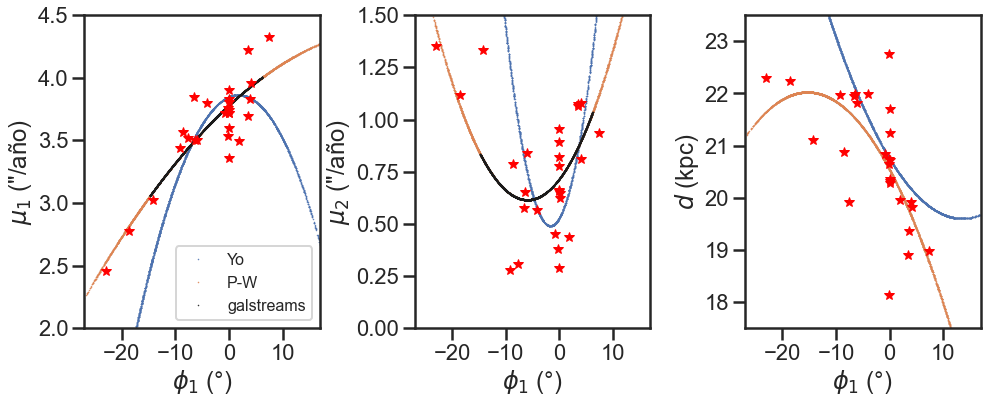

In [11]:
import init

miembro = (data['Track']==1) & (data['Memb']>0.5)

post = flat_samples[:, -1]
    
MAP = max(post)
theta_max = flat_samples[np.argmax(post)]

print('MAP del MCMC:\n ', theta_max,'\n')
print('Valores del paper: \n',theta_true)


#MCMCM
y_mu1 = init.model(phi1.value, theta_max[0], theta_max[3], theta_max[6], theta_max[9])
y_mu2 = init.model(phi1.value, theta_max[1], theta_max[4], theta_max[7], theta_max[10])
y_d = init.model(phi1.value, theta_max[2], theta_max[5], theta_max[8], theta_max[11])

#Paper
yy_mu1 = init.model(phi1.value, theta_true[0], theta_true[3], theta_true[6], theta_true[9])
yy_mu2 = init.model(phi1.value, theta_true[1], theta_true[4], theta_true[7], theta_true[10])
yy_d = init.model(phi1.value, theta_true[2], theta_true[5], theta_true[8], theta_true[11])


fig=plt.figure(1,figsize=(15,5))
fig.subplots_adjust(wspace=0.4,hspace=0.3,top=0.98,bottom=0.11,left=0.14,right=0.97)
ax=fig.add_subplot(131)
ax.plot(phi1, y_mu1,'.', ms=1, label='Yo')
ax.plot(phi1, yy_mu1,'.', ms=1, label='P-W')
ax.plot(phi1_t, pmphi1_t,'k.', ms=1, label='galstreams')
ax.plot(phi1[miembro],pmphi1[miembro],'*',c='red',ms=10.)
ax.legend(fontsize=16,loc='lower right')
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_1$ ("/año)')
ax.set_xlim([-27,17])
ax.set_ylim([2.,4.5])
# ax.set_xlim([-16,8])
# ax.set_ylim([3.,4.1])

ax=fig.add_subplot(132)
ax.plot(phi1, y_mu2,'.', ms=1)
ax.plot(phi1, yy_mu2,'.', ms=1)
ax.plot(phi1_t, pmphi2_t,'k.', ms=1)
ax.plot(phi1[miembro],pmphi2[miembro],'*',c='red',ms=10.)
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_2$ ("/año)')
ax.set_xlim([-27,17])
ax.set_ylim([0.,1.5])
# ax.set_xlim([-16,8])
# ax.set_ylim([0.5,1.2])

ax=fig.add_subplot(133)
ax.plot(phi1, y_d,'.', ms=1)
ax.plot(phi1, yy_d,'.', ms=1)
ax.plot(phi1[miembro],d[miembro],'*',c='red',ms=10.)
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$d$ (kpc)')
ax.set_xlim([-27,17])
ax.set_ylim([17.5,23.5]);

## Estrellas miembros N=7

Corrida del script solamente para las estrellas que son miembro según PW19, con N=7 gaussinas para el fondo. Al igual que para N=7, los resultados siguen siendo muy sensibles a la corrida

Inicio:  2022-10-11 01:18:35.940330 


Cargando datos 

Cargando track y transformando coordenadas 

Initializing galstreams library from master_log... 

Modelo de fondo 

MCMC
Valores iniciales:  [ 3.74738665e+00  7.47412757e-01  2.10332153e+01  3.65011653e-02
  4.16815362e-02 -1.41448994e-01 -8.43218188e-04  2.90241029e-03
 -4.86381069e-03 -6.71315472e-01  1.83603764e+00 -3.18303887e+00
  8.18181818e-03]


  8%|▊         | 4/50 [00:00<00:04, 11.45it/s]

C:\Users\win8.1\Documents\Fcien\Astronomia\galstreams\stream_memb\Price+2019\probs.py:32: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta_st)

C:\Users\win8.1\Documents\Fcien\Astronomia\galstreams\stream_memb\Price+2019\probs.py:35: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



 65%|██████▍   | 2648/4096 [03:42<02:07, 11.33it/s]

C:\Users\win8.1\Documents\Fcien\Astronomia\galstreams\stream_memb\Price+2019\probs.py:33: RuntimeWarning: invalid value encountered in log
  arg2 = np.log(1.-f) + ll_bgn



100%|██████████| 4096/4096 [05:45<00:00, 11.87it/s]


349.56462502479553
Tamano muestra: (42536, 13)


Guardando muestras 

Guardando membresias 



SolID                       DR2Name          Memb  inside10  \
0   1635721458409799680  Gaia DR2 4418724034151291776  4.012660e-01      True   
1   1635721458409799680  Gaia DR2 4418920808077110784  4.819897e-01      True   
2   1635721458409799680  Gaia DR2 6339398155830632448  2.642140e-01      True   
3   1635721458409799680  Gaia DR2 4418913218870688768  4.742519e-01      True   
4   1635721458409799680  Gaia DR2 4418726027016125056  1.345940e-02     False   
5   1635721458409799680  Gaia DR2 4427220338456828416  2.869738e-01      True   
6   1635721458409799680  Gaia DR2 4421078432143578496  4.303371e-01      True   
7   1635721458409799680  Gaia DR2 6339478312804685824  3.366672e-01      True   
8   1635721458409799680  Gaia DR2 4427234700827469952  2.137236e-01      True   
9   1635721458409799680  Gaia DR2 4418732791593809152  4.439659e-01      True   
10  1635721458409799680  Gaia DR2 4419052204012341760  5.412636e-01      True   
11  1635721458409799680  Gaia DR2 4418725889577171328  9.847221e-02     False   
12  1635721458409799680  Gaia DR2 6339499379619987200  1.855306e-02     False   
13  1635721458409799680  Gaia DR2 4424705647988505600  8.360213e-03     False   
14  1635721458409799680  Gaia DR2 6339498589346000768  2.610138e-02     False   
15  1635721458409799680  Gaia DR2 4427253907921168000  2.565449e-01      True   
16  1635721458409799680  Gaia DR2 4418920846732620032  5.882494e-03     False   
17  1635721458409799680  Gaia DR2 4426221707021159424  2.326560e-02     False   
18  1635721458409799680  Gaia DR2 6337233350579111680  3.829333e-02     False   
19  1635721458409799680  Gaia DR2 4418914863842345856  2.474700e-05     False   
20  1635721458409799680  Gaia DR2 4418142117622280192  4.364427e-02     False   
21  1635721458409799680  Gaia DR2 4418734165978521728  1.390418e-02     False   
22  1635721458409799680  Gaia DR2 4427646704153765632  1.704581e-03     False   
23  1635721458409799680  Gaia DR2 4439927909737905280  3.201686e-02     False   
24  1635721458409799680  Gaia DR2 4445607604551159040  1.747142e-02     False   
25  1635721458409799680  Gaia DR2 4418731829516302848  1.003605e-15     False   
26  1635721458409799680  Gaia DR2 4450058431917932672  6.318419e-03     False   

    inside50  
0      False  
1      False  
2      False  
3      False  
4      False  
5      False  
6      False  
7      False  
8      False  
9      False  
10      True  
11     False  
12     False  
13     False  
14     False  
15     False  
16     False  
17     False  
18     False  
19     False  
20     False  
21     False  
22     False  
23     False  
24     False  
25     False  
26     False

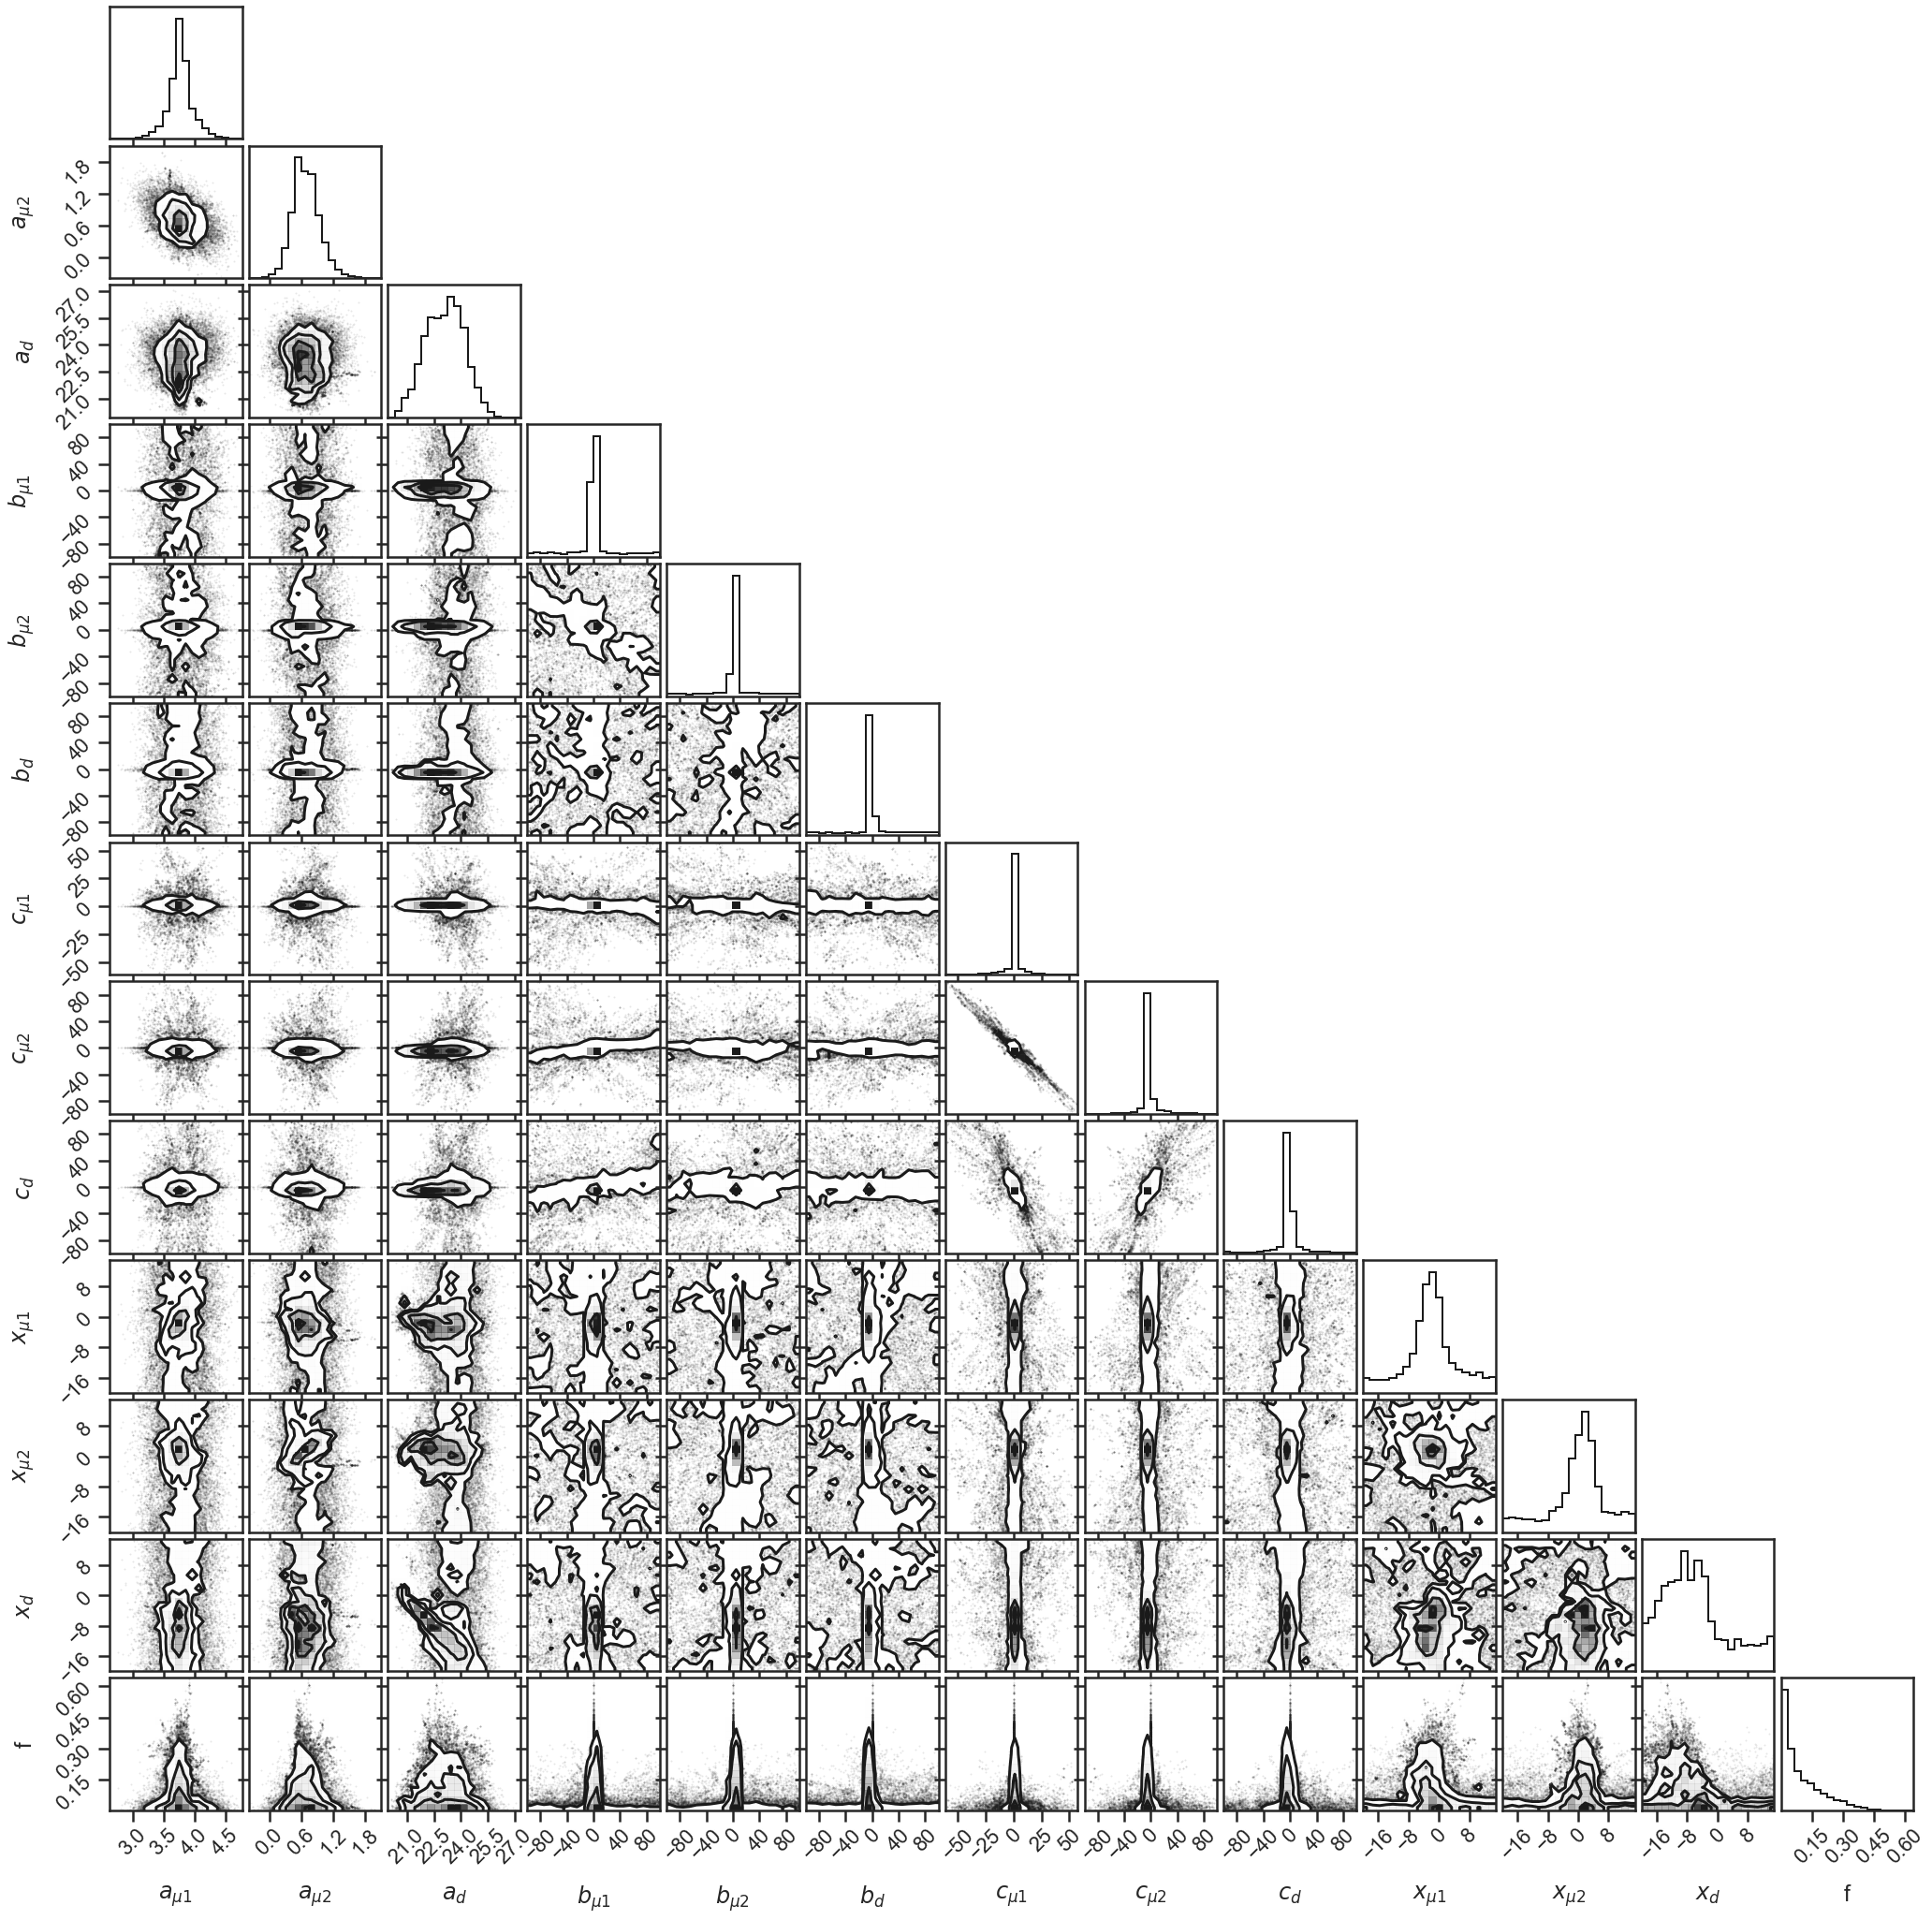

In [16]:
import parametros
import datos
import fondo
import probs
import init
import resultados 
# import blobs_aux

import numpy as np
import pandas as pd
import pylab as plt
import scipy
import seaborn as sns
sns.set(style="ticks", context="poster")


# import os #Avoids issues with paralellization in emcee
# os.environ["OMP_NUM_THREADS"] = "1"
# from multiprocessing import Pool
# from multiprocessing import cpu_count
import datetime, time
import emcee
import corner	


Start = datetime.datetime.now()

print('Inicio: ', Start, '\n')

# print('Cargo datos \n')
tabla, st, printTrack, do_bg_model, printBIC, N_inf, N_sup, d_inf, d_sup, C11, C22, C33, d_mean, e_dd, mu1_mean, mu2_mean, e_mu1, e_mu2, cov_mu, lim_unif, nwalkers, ndim, steps, burn_in, thin, q_min, q_max = parametros.parametros()

data, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, phi1_t, phi2_t, pmphi1_t, pmphi2_t, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out, footprint = datos.datos(tabla, st, printTrack, d_inf, d_sup)

miembro_PW = (data['Track']==1) & (data['Memb']>0.5)

y = np.array([pmphi1.value[miembro_PW], pmphi2.value[miembro_PW], d[miembro_PW]])
C = np.array([[C11, 0, 0], [0, C22, 0], [0, 0, C33]]) #Matriz de covarianza de la corriente: mov propios y distancia (fija)

mu = np.array([mu1_mean, mu2_mean])
sigma = np.array([[(e_mu1*10)**2, (cov_mu*100)], [(cov_mu*100), (e_mu2*10)**2]]) #Matriz de covarianza del prior gaussiano de los movimientos propios en el frame de la corriente

#Para que funcione tengo que primero asignarle las variables globales al modulo probs
probs.phi1 = phi1[miembro_PW]
probs.y = y
probs.C = C

print('\nModelo de fondo \n')
N = np.arange(N_inf, N_sup) #Vector con numero de gaussianas
#ll_bgn, p_bgn, gmm_best, BIC = fondo.fondo(do_bg_model, printBIC, N, pmra, pmdec, d, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out)
ll_bgn = np.load('ll_bgn7.npy')
p_bgn = np.load('p_bgn7.npy')

probs.ll_bgn = ll_bgn[miembro_PW]
probs.p_bgn = p_bgn[miembro_PW]


print('MCMC')
pos0 = init.init_ls(phi1, pmphi1, pmphi2, d, miembro_PW, nwalkers, ndim) #Inicializo haciendo minimos cuadrados con las estrellas que ya se que son miembros segun PW2019

#SERIAL RUN
dtype = [("(arg1, arg2)", object)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, probs.ln_posterior, args=(mu, sigma, d_mean, e_dd, lim_unif), blobs_dtype=dtype)
start = time.time()
pos, _, _, _ = sampler.run_mcmc(pos0, burn_in, progress=True)
sampler.reset()
sampler.run_mcmc(pos, steps, progress=True)
end = time.time()
serial_time = end-start
print(serial_time)

# tau = sampler.get_autocorr_time()
# print('tau: ', tau)
# print('tau promedio: {}'.format(np.mean(tau)))

flat_samples = sampler.get_chain(discard=0, thin=thin, flat=True)
print('Tamano muestra: {}'.format(flat_samples.shape))

columns = ["$a_{\mu1}$", "$a_{\mu2}$", "$a_d$", "$b_{\mu1}$", "$b_{\mu2}$", "$b_d$", "$c_{\mu1}$", "$c_{\mu2}$", "$c_d$", "$x_{\mu1}$", "$x_{\mu2}$", "$x_d$", "f"]
theta_post = pd.DataFrame(flat_samples, columns=columns)


fig6 = corner.corner(flat_samples, labels=columns, labelpad=0.25)
fig6.subplots_adjust(bottom=0.05,left=0.05)
fig6.savefig('corner_plot_miembros7.png')


print('Guardando muestras \n')

##Guardo las posteriors
post = sampler.get_log_prob(discard=0, thin=thin, flat=True)

theta_post['Posterior'] = post
theta_post.to_csv('theta_post_miembros7.csv', index=False)


print('Guardando membresias \n')

##Prob de membresia al stream
flat_blobs = sampler.get_blobs(discard=0, thin=thin, flat=True)
memb = resultados.memb(phi1[miembro_PW], flat_blobs)

inside10 = memb > 0.1 
inside50 = memb > 0.5

Memb = pd.DataFrame({'SolID': data['SolID'][miembro_PW], 'DR2Name': data['DR2Name'][miembro_PW], 'Memb': memb,'inside10': inside10, 'inside50': inside50})
Memb.to_csv('memb_prob_miembros7.csv', index=False)

Memb

MAP del MCMC:
  [ 3.91862766e+00  7.30070984e-01  2.29649697e+01  1.50861717e-02
  9.56264277e-02 -3.34152767e-02 -8.30391350e-04  1.12554066e-02
 -6.94939832e-03  6.62494832e+00  2.34828524e+00 -1.51516454e+01
  6.40116667e-01] 

Valores del paper: 
 [ 3.74000000e+00  6.86000000e-01  2.20220000e+01  4.10200000e-02
 -2.82600000e-02  9.46000000e-03 -6.42300000e-04  2.83200000e-03
 -6.32700000e-03 -1.07200000e+00 -1.09540000e+01 -1.60810000e+01
  8.18181818e-03]


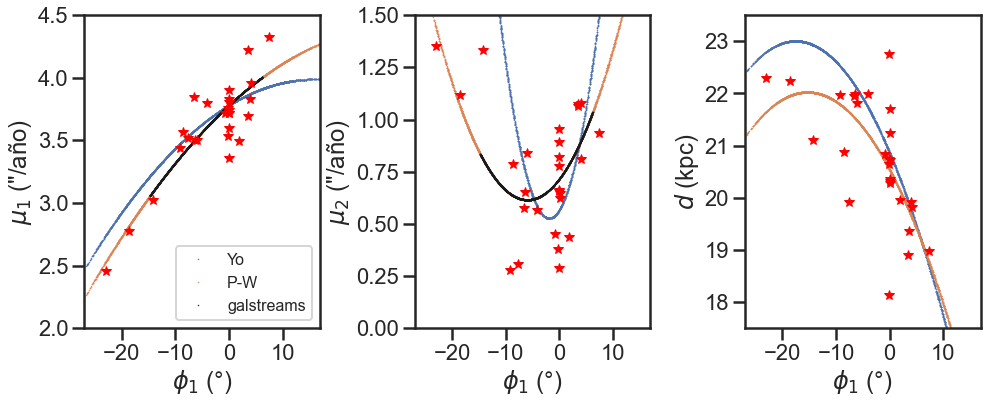

In [17]:
miembro = (data['Track']==1) & (data['Memb']>0.5)

post = flat_samples[:, -1]
    
MAP = max(post)
theta_max = flat_samples[np.argmax(post)]

print('MAP del MCMC:\n ', theta_max,'\n')
print('Valores del paper: \n',theta_true)


#MCMCM
y_mu1 = init.model(phi1.value, theta_max[0], theta_max[3], theta_max[6], theta_max[9])
y_mu2 = init.model(phi1.value, theta_max[1], theta_max[4], theta_max[7], theta_max[10])
y_d = init.model(phi1.value, theta_max[2], theta_max[5], theta_max[8], theta_max[11])

#Paper
yy_mu1 = init.model(phi1.value, theta_true[0], theta_true[3], theta_true[6], theta_true[9])
yy_mu2 = init.model(phi1.value, theta_true[1], theta_true[4], theta_true[7], theta_true[10])
yy_d = init.model(phi1.value, theta_true[2], theta_true[5], theta_true[8], theta_true[11])


fig=plt.figure(1,figsize=(15,5))
fig.subplots_adjust(wspace=0.4,hspace=0.3,top=0.98,bottom=0.11,left=0.14,right=0.97)
ax=fig.add_subplot(131)
ax.plot(phi1, y_mu1,'.', ms=1, label='Yo')
ax.plot(phi1, yy_mu1,'.', ms=1, label='P-W')
ax.plot(phi1_t, pmphi1_t,'k.', ms=1, label='galstreams')
ax.plot(phi1[miembro],pmphi1[miembro],'*',c='red',ms=10.)
ax.legend(fontsize=16,loc='lower right')
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_1$ ("/año)')
ax.set_xlim([-27,17])
ax.set_ylim([2.,4.5])
# ax.set_xlim([-16,8])
# ax.set_ylim([3.,4.1])

ax=fig.add_subplot(132)
ax.plot(phi1, y_mu2,'.', ms=1)
ax.plot(phi1, yy_mu2,'.', ms=1)
ax.plot(phi1_t, pmphi2_t,'k.', ms=1)
ax.plot(phi1[miembro],pmphi2[miembro],'*',c='red',ms=10.)
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_2$ ("/año)')
ax.set_xlim([-27,17])
ax.set_ylim([0.,1.5])
# ax.set_xlim([-16,8])
# ax.set_ylim([0.5,1.2])

ax=fig.add_subplot(133)
ax.plot(phi1, y_d,'.', ms=1)
ax.plot(phi1, yy_d,'.', ms=1)
ax.plot(phi1[miembro],d[miembro],'*',c='red',ms=10.)
ax.set_xticks([-20,-10,0,10])
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$d$ (kpc)')
ax.set_xlim([-27,17])
ax.set_ylim([17.5,23.5]);

# test init

In [7]:
import numpy as np
import init

mu = np.array([mu1_mean, mu2_mean])
sigma = np.array([[(e_mu1*10)**2, (cov_mu*100)], [(cov_mu*100), (e_mu2*10)**2]])

inside = (data['Track']==1)
miembro = inside & (data['Memb']>0.5)

pos1 = init.init_prior(mu, sigma, d_mean, e_dd, lim_unif, nwalkers, ndim)
print(pos1[0])

pos2 = init.init_ls(phi1, pmphi1, pmphi2, d, miembro, nwalkers, ndim)
print(pos2[0])

[ 3.88218411e+00  6.33699801e-01  2.29415780e+01 -1.35230560e-01
 -1.79624789e-01  3.76620871e-01  1.38137055e-01  1.06576468e-01
  4.96749131e-01 -1.20698376e+01  1.01630564e+01 -1.45316962e+01
  1.16118894e-02]
Valores iniciales:  [ 3.74738665e+00  7.47412757e-01  2.10332153e+01  3.65011653e-02
  4.16815362e-02 -1.41448994e-01 -8.43218188e-04  2.90241029e-03
 -4.86381069e-03 -6.71315472e-01  1.83603764e+00 -3.18303887e+00
  8.18181818e-03]
[ 3.17092558e+00  6.89493787e-01  2.55128227e+01  3.63293447e-02
  4.23749834e-02 -1.46752253e-01 -8.10394424e-04  3.19849861e-03
 -5.26385167e-03 -6.36649251e-01  1.90462311e+00 -3.71434429e+00
  8.55610018e-03]
